# This is the script to extract Liver bounding!

In [7]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
#len(os.listdir('../../Data/CT_Phase/Full_Image_Liver_07075/'))

In [1]:
import os
import nibabel as nib
import numpy as np
import skimage 
import matplotlib.pyplot as plt
from tqdm import tqdm
import SimpleITK as sitk
import nibabel as nib
import math
import pandas as pd
#print(os.listdir('../../Test_Data/Test_3D/'))
def merge_overlapping_ranges(range_dict):
    # 初始化结果字典
    merged_dict = {}

    # 遍历输入字典的每个键和值
    for sample, ranges in range_dict.items():
        # 对范围进行排序并初始化临时列表
        sorted_ranges = sorted(ranges, key=lambda x: x[0])
        merged_ranges = []

        # 从第一个范围开始
        current_start, current_end = sorted_ranges[0]

        for start, end in sorted_ranges[1:]:
            # 如果当前范围与上一个范围重叠
            if start <= current_end:
                # 合并范围
                current_end = max(current_end, end)
            else:
                # 如果当前范围不重叠，添加前一个范围到列表并更新当前范围
                merged_ranges.append((current_start, current_end))
                current_start, current_end = start, end

        # 添加最后一个范围到列表
        merged_ranges.append((current_start, current_end))

        # 将合并后的范围列表添加到结果字典
        merged_dict[sample] = merged_ranges

    return merged_dict


def generate_sample_ranges(sample_dict):
    # 初始化一个列表来存储结果
    result = []
    
    # 遍历字典中的每个样本及其范围
    for sample_id, ranges in sample_dict.items():
        # 对于每个样本的每个范围，创建一个新的标识符并添加到结果列表中
        for index, range_tuple in enumerate(ranges, start=1):
            
            new_id = f"{sample_id[0:13]}{index}_{sample_id[15:]}"
            min_slice, max_slice = range_tuple
            result.append({'ID': new_id, 'Min Slice': min_slice, 'Max Slice': max_slice})
    
    return result
def select_non_overlapping(tuples_list):
    # 按照每个元组的第一个元素进行排序
    sorted_tuples = sorted(tuples_list, key=lambda x: x[0])

    # 初始化结果列表
    non_overlapping = []

    # 遍历排序后的列表
    for current in sorted_tuples:
        # 如果结果列表为空或者当前元组的开始大于结果列表中最后一个元组的结束，则添加当前元组到结果列表
        if not non_overlapping or current[0] > non_overlapping[-1][1]:
            non_overlapping.append(current)

    return non_overlapping
def components_to_array(components):
    # 假设所有组件的形状都是相同的
    component_shapes = list(components.values())[0].shape
    # 创建一个新的数组，其第一个维度是键的数量
    num_components = len(components)
    new_array = np.zeros((num_components,) + component_shapes, dtype=int)

    for i, (key, value) in enumerate(components.items()):
        new_array[i] = value

    return new_array
class ImageLoad:
    def __init__(self,input_path):
        """
        The path should only contain images
        """
        self.input_path = input_path


        #self.images_names = os.listdir('../../Test_Data/Test_3D/')
        self.images_names = os.listdir(self.input_path)
        self.images_num = len(self.images_names)
        self.image_path = [self.input_path + name for name in self.images_names]

    def image_load(self,image_path,reader='sitk'):
        if reader == 'nib':
            return nib.load(image_path)
        elif reader == 'sitk':
            return sitk.ReadImage(image_path)
        else:
            raise ValueError("The reader should be either nib or sitk!")
        
    #def image_get_float(self):

  


class LiverBoundingBox:
    def __init__(self,liver_mask,liver_orig,out_path_box=None,file_name=None):
        """
        args:
            liver_mask: the liver mask|nib or sitk
            original_image: the original image|nib or sitk
        """
        self.liver_seg = liver_mask
        self.liver_orig = liver_orig
        self.out_path_box = out_path_box
        self.file_name = file_name
        # self.original_image = original_image
        # self.liver_mask_array = self._get_array(liver_seg)
        # self.original_arrary = self._get_array(original_image)
        # self.image_loader = image_loader
    def extract_liver(self,liver=True,no_connection=True):
        """
            get either the liver or tumor region from the mask
            args:
                mask: mask of the liver and tumor
                liver: if True return the liver region, if False return the tumor region
        """
        mask = self._get_array(self.liver_seg)
        mask = mask.astype(int)
        mask[mask == 2] = 0
        print(mask.shape)
        labeled,num_features = skimage.measure.label(mask, connectivity=2,return_num=True)

        max_label = 0
        max_size = 0
        for label in range(1, num_features + 1):
            label_size = np.sum(labeled == label)
            if label_size > max_size:
                max_label = label
                max_size = label_size

        # keep only the largest connected component
        mask = np.where(labeled == max_label, 1, 0)

       
            

        return mask


    def extract_tumor(self,largest=True):
        mask = self._get_array(self.liver_seg)
        mask = mask.astype(int)
       # print(mask.shape)

        mask[mask == 1] = 0
        mask[mask == 2] = 1
        mask = mask.astype(int)
    
        labeled,num_features = skimage.measure.label(mask, connectivity=2,return_num=True)
        #find each connected component and find the largest one

        if num_features <= 1:
            return {1:labeled}

        if largest:
            #print(33)
            max_label = 0
            max_size = 0
            for label in range(1, num_features + 1):
                label_size = np.sum(labeled == label)
                if label_size > max_size:
                    max_label = label
                    max_size = label_size

            # keep only the largest connected component
            mask = np.where(labeled == max_label, 1, 0)

            return mask
        else:
            components = {}  
            for label in range(1, num_features + 1):
                component_mask = np.where(labeled == label, 1, 0)
                components[label] = component_mask
            #print(components,666)
            return components
            # return all the connected components




    def tumor_bbox(self, tumor_mask):
        """
        args:
            tumor_mask: the tumor mask, list or dict
        """
        # 存储包含肿瘤的切片索引
        if isinstance(tumor_mask, np.ndarray):
            tumor_mask = tumor_mask   
            #add one more dimension
            tumor_mask = np.expand_dims(tumor_mask, axis=0)
        elif isinstance(tumor_mask, dict):
            tumor_mask = components_to_array(tumor_mask)
        
        tumor_slices = []

        # check each tumor
        for i in range(tumor_mask.shape[0]):  # how many slices
            tumor_slice = []
            tumor_mask_i = tumor_mask[i, :, :,:]
            # check each tumor slice
            for j in range(tumor_mask_i.shape[0]):
                slice = tumor_mask_i[j, :, :]
                if np.any(slice):
                    tumor_slice.append(j)
                 
            
            tumor_slice_lower = tumor_slice[0]
            tumor_slice_upper = tumor_slice[-1]
            tumor_slices.append((tumor_slice_lower, tumor_slice_upper))

        return tumor_slices




    """
    def tumor_bbox(self,tumor_mask, bbox_size = (36, 36,27)):
        '''
        find the center of mass of the tumor and return the bounding box
        args:
            tumor_mask: binary mask of the tumor
        returns:
            bbox: bounding box of the tumor (min_row, min_col, min_slice, max_row, max_col, max_slice = bbox)
        '''
        # find the center of mass of the tumor
        com = self.get_center_of_mass_3D(tumor_mask)
        com = np.array(com).astype(int)

        # extract bbox around the center of mass
        #should be max! should not under zero!
        min_slice = com[0] - bbox_size[0]//2
        max_slice = com[0] + bbox_size[0]//2
        min_row = com[1] - bbox_size[1]//2
        max_row = com[1] + bbox_size[1]//2
        min_col = com[2] - bbox_size[2]//2
        max_col = com[2] + bbox_size[2]//2
        print(min_row, min_col, min_slice, max_row, max_col, max_slice)
    
        return min_row, min_col, min_slice, max_row, max_col, max_slice
    

    def get_center_of_mass_3D(self,binary_image):
        # Label the connected components in the binary image
        labeled_image = skimage.measure.label(binary_image)
        
        # Compute region properties including center of mass
        props = skimage.measure.regionprops_table(labeled_image, properties=['centroid'])
        print(props)
        # Get the center of mass coordinates
        center_row = np.mean(props['centroid-0'])
        center_col = np.mean(props['centroid-1'])
        center_slice = np.mean(props['centroid-2'])
        
        # Return the center of mass coordinates as a tuple
        center_of_mass = (center_row, center_col, center_slice)
        return center_of_mass
    """
    def get_liver_bounding_box(self,liver_mask):
        '''
    Function to generate bounding box for liver, from a binary liver mask
        args:
            liver_mask: binary mask of the liver

        returns:
            bbox: bounding box of the liver (min_row, min_col, min_slice, max_row, max_col, max_slice = bbox)
        '''

        # get the image_probs
        image_probs = skimage.measure.regionprops((liver_mask))

        # get the bounding box of the liver

        if len(image_probs) == 0:
            print(f'[WARNING] no liver found')
            self._recording_failing()
            return None

        ## find the adjacent box that contains the liver
        for props in image_probs:
            bbox = props.bbox
            print(bbox)
            min_slice, min_col, min_row, max_slice, max_col, max_row = bbox 
            print("this is range",min_slice, min_col, min_row, max_slice, max_col, max_row)
        return [min_slice, min_col, min_row, max_slice, max_col, max_row]

    def crop_scan(self,liver_bounding):
        """
        Crop the scan with the bounding box
        args:
            liver_bounding: the bounding box of the liver
        """
        liver_original = self._get_array(self.liver_orig)
        # get the bounding box of the liver
        min_row, min_col, min_slice, max_row, max_col, max_slice = list(map(self._check_range,liver_bounding))
        print('this is after check range',min_row, min_col, min_slice, max_row, max_col, max_slice)
        
        #crop the scan
        cropped_scan = liver_original[min_row:max_row,min_col:max_col,min_slice:max_slice]
        return cropped_scan
    
    def store_cropped_data(self,cropped_data):

        if not os.path.exists(self.out_path_box):
            os.mkdir(self.out_path_box)
            print('The path does not exist, create the path!')

        header = self.liver_orig.header
        affine = self.liver_orig.affine
        print("this is shape of cropped data",cropped_data.shape)
        cropped_image = nib.Nifti1Image(cropped_data, affine, header)


        
        nib.save(cropped_image, self.out_path_box + self.file_name)

    @staticmethod   
    def liver_detection(mask):
        if np.count_nonzero(mask) != 0:
            return True


    def _check_range(self,range_num):
        return max(0,range_num)
    
    def _get_array(self,image_file):
        return sitk.GetArrayFromImage(image_file)
    
    def _recording_failing(self):
        with open(self.out_path_box + 'failing_box.txt','a') as f:
            f.write(self.file_name + '\n')

def per_tumor_size(component):
    """
    get the size of each tumor
    args:
        component: the tumor component dict
    """
    per_tumor_szie = []
    for key, value in component.items():
        print(f'Tumor {key} size: {np.sum(value)}')
        per_tumor_szie.append(np.sum(value))
    return per_tumor_szie





C:\Users\098986\AppData\Local\Temp\ipykernel_29040\229249417.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# get per tumor mask

In [19]:
#read per tumor csv
per_tumor_info = pd.read_csv('../Experiments/data_info/per_tumor_bbx.csv')
per_tumor_info.slice_depth.quantile([0.25,0.5,0.75])

0.25     4.0
0.50     9.0
0.75    17.0
Name: slice_depth, dtype: float64

In [12]:
# Apply the logic to adjust min_slice and max_slice based on slice_depth

# Display the first few rows of the updated dataframe to verify 

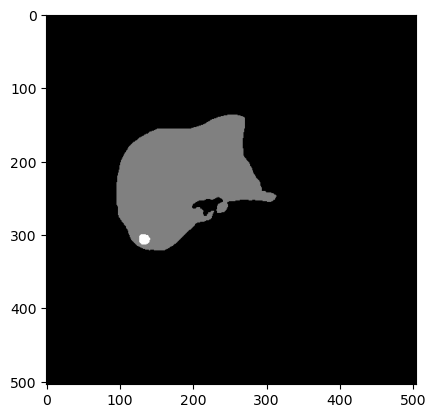

: 

In [76]:
img = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_07071_windowed_+20/CILM_CT_100330_0000.nii.gz')
img_mask = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/CILM_CT_100430.nii.gz')

img = sitk.GetArrayFromImage(img)
img_mask = sitk.GetArrayFromImage(img_mask)
#img_mask[img_mask == 1] = 0
plt.imshow(img_mask[390,:,:], cmap='gray')

In [9]:
import numpy as np

# 假设 mask 是您的三维数组
mask = np.random.randint(2, size=(5, 5, 5))  # 生成一个示例三维数组，大小为 5x5x5

# 找到值为1的元素的索引
ones_indices = np.argwhere(mask == 1)

# 如果mask中至少有一个1，计算边界框
if ones_indices.size > 0:
    # 分别找到所有维度上的最小和最大索引
    min_z, min_y, min_x = ones_indices.min(axis=0)
    max_z, max_y, max_x = ones_indices.max(axis=0)

    # 构建边界框
    bounding_box = ((min_z, min_y, min_x), (max_z, max_y, max_x))
    print("Bounding box:", bounding_box)
else:
    print("数组中没有值为1的元素，无法构建边界框。")


Bounding box: ((0, 0, 0), (4, 4, 4))


In [10]:
import numpy as np

def tumor_bounding_box(mask_component,extra_slice= (0,0,0)):
    bounding_box_dict = {'min_row':[],'min_col':[],'min_slice':[],'max_row':[],'max_col':[],'max_slice':[]}
    for key, value in mask_component.items():
        mask = value
        ones_indices = np.argwhere(mask == 1)
        if ones_indices.size > 0:
            # 分别找到所有维度上的最小和最大索引
            min_z, min_y, min_x = ones_indices.min(axis=0)
            max_z, max_y, max_x = ones_indices.max(axis=0)

            # 构建边界框
            bounding_box = ((min_z, min_y, min_x), (max_z, max_y, max_x))
            bounding_box_dict['min_row'].append(min_x)
            bounding_box_dict['min_col'].append(min_y)
            bounding_box_dict['min_slice'].append(min_z)
            bounding_box_dict['max_row'].append(max_x)
            bounding_box_dict['max_col'].append(max_y)
            bounding_box_dict['max_slice'].append(max_z)


            print("Bounding box:", bounding_box)
        else:
            print("数组中没有值为1的元素，无法构建边界框。")
    return bounding_box_dict



tumor_bounding_box(mask_tumor,(0,0,0))

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [197]:
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_07071/")
image_seg_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_mask_07071/")
cropped_out_path = '../../Data/Mixed_HGP/Miexed_HGP_Liver_Cropped/'
#get the tumor slice
tumor_slice = {}
#get the tumor size
tumor_size = {}
tumor_bbx = {}
liver_slice = {}
tumor_mask_dic = {}
for i in range(40):
  
    file_name = image_orig_load.images_names[i]
 

    # load the image
    image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    liver_bbox = LiverBoundingBox(image_seg,image_orig,cropped_out_path,file_name)
    mask_liver = liver_bbox.extract_liver()
    liver_bbx = liver_bbox.get_liver_bounding_box(mask_liver)
    #crop the liver
    liver_slice[file_name] = liver_bbx
    # extract each single tumor
    mask_tumor= liver_bbox.extract_tumor(largest=False)
    #tumor_slices = liver_bbox.tumor_bbox(mask_tumor)
    #tumor_slice[file_name] = tumor_slices
    tumor_mask_dic[file_name] = mask_tumor
    
    #get the tumor size
    #tumor_size[file_name] = per_tumor_size(mask_tumor) 
    #tumor bounding box
    #tumor_bbx[file_name] = tumor_bounding_box(mask_tumor,(0,0,0))
    #get non-overlapping slices
    #non_overlapping_slices = select_non_overlapping(tumor_slices)
    #tumor_slice[file_name] = non_overlapping_slices
    



(250, 407, 407)
(61, 94, 43, 237, 306, 288)
this is range 61 94 43 237 306 288
(420, 504, 504)


KeyboardInterrupt: 

In [73]:
tumor_mask_dic['CILM_CT_100430_0000.nii.gz'][4].shape

(420, 504, 504)

# Get single tumor mask


In [8]:
#calculate tumor size
#merged_df_ = pd.read_csv('../Experiments/data_info/merged_per_tumor_size_07071.csv')
image_folder = '../../Data/Mixed_HGP/Mixed_HGP_mask_07071/'

Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]
cropped_out_path = None
tumor_sizes = []

In [102]:
liver_bbx

,Sample,min_col,min_row,max_col,max_row
0,CILM_CT_100330_0000.nii.gz,94,43,306,288
1,CILM_CT_100430_0000.nii.gz,122,61,374,314
2,CILM_CT_101040_0000.nii.gz,90,62,375,336
3,CILM_CT_102030_0000.nii.gz,93,48,385,353
4,CILM_CT_107020_0000.nii.gz,169,112,440,376
...,...,...,...,...,...
244,CILM_CT_893200_0000.nii.gz,114,37,353,329
245,CILM_CT_941310_0000.nii.gz,92,39,339,272
246,CILM_CT_949120_0000.nii.gz,100,35,353,308
247,CILM_CT_975750_0000.nii.gz,138,101,352,396


In [106]:
liver_info = pd.read_csv('../Experiments/data_info/per_tumor_bbx_adjusted_64_64_32.csv')
liver_bbx_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/Liver_bounding_07071/liver_bbx.csv')
#sample_values = liver_info['sample'].drop_duplicates().iloc[:40]
per_tumor_info.to_csv('../Experiments/data_info/per_tumor_bbx.csv',index=False

In [107]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
image_folder = '../../Data/Mixed_HGP/Mixed_HGP_07071/'


image_folder_per_tumor_mask = '../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/'

Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_07071/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]



Mixed_HGP_Data_per_tumor_mask = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/')
Mixed_HGP_Data_per_tumor_mask = [os.path.abspath(os.path.join(image_folder_per_tumor_mask, f)) for f in os.listdir(image_folder_per_tumor_mask)]
output_folder = '../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)


#get bounding info 
liver_info = pd.read_csv('../Experiments/data_info/per_tumor_bbx.csv')

row

Sample                  CILM_CT_192810_0000.nii.gz
min_row                                         55
min_col                                        154
min_slice                                      238
max_row                                        158
max_col                                        290
max_slice                                      327
sample                                       19281
tumor_size                                  512200
sample_id                                       67
tumor_id                                         0
row_depth                                      103
col_depth                                      136
slice_depth                                     89
adjusted_min_slice                             238
adjusted_max_slice                             327
lv_min_row                                     NaN
lv_max_row                                     NaN
lv_min_col                                     NaN
lv_max_col                     

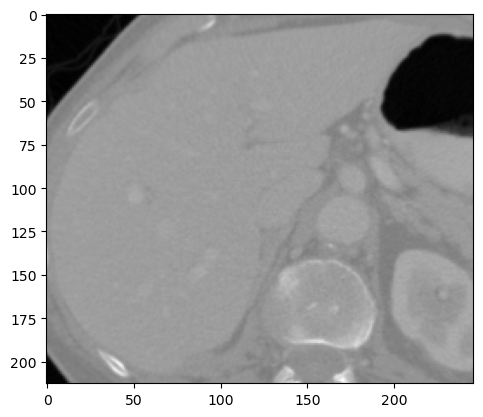

In [50]:
img = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_07071/CILM_CT_100330_0000.nii.gz')
img_array = sitk.GetArrayFromImage(img)

plt.imshow(img_array[160,94:307,43:289], cmap='gray')

In [108]:


for index,row in liver_info.iterrows():
    
   
    
    #out_name = os.path.basename(Mixed_HGP_Data_per_tumor_mask[index])
    #choose largest tumor id
    base_path = '../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/'
    tumor_id = str(row['tumor_id'])
    out_name = row['Sample'][0:18]+tumor_id+'.nii.gz'
    img_mask = sitk.ReadImage(base_path +out_name)
    img_mask_array = sitk.GetArrayFromImage(img_mask)
    print('fuck',img_mask_array.sum())

    min_slice,max_slice,min_col,max_col,min_row,max_row = row[['adjusted_min_slice','adjusted_max_slice','lv_min_col','lv_max_col','lv_min_row','lv_max_row']]
    #integer
    min_slice,max_slice,min_col,max_col,min_row,max_row = int(min_slice),int(max_slice),int(min_col),int(max_col),int(min_row),int(max_row)


        #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,max_row,max_col,min_slice,max_slice,'555')
    print(img_mask_array.shape)
    print(out_name)
    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    min_slice = max(0,min_slice)
    max_slice = min(max_slice,img_mask_array.shape[0])
    min_row = max(0,min_row)
    max_row = min(max_row,img_mask_array.shape[2])
    min_col = max(0,min_col)
    max_col = min(max_col,img_mask_array.shape[1])
    #extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    extracted_slices = img_mask_array[min_slice:max_slice+1,min_col:max_col+1, min_row:max_row+1]
    #print('size',extracted_slices.sum())
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img_mask.GetSpacing())
    extracted_img.SetDirection(img_mask.GetDirection())
    extracted_img.SetOrigin(img_mask.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    print(output_path,'output save')
    sitk.WriteImage(extracted_img, output_path)



fuck 858
43 94 288 306 112 133 555
(250, 407, 407)
CILM_CT_100330_0000.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/CILM_CT_100330_0000.nii.gz output save
fuck 5306
43 94 288 306 130 155 555
(250, 407, 407)
CILM_CT_100330_0001.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/CILM_CT_100330_0001.nii.gz output save
fuck 16
43 94 288 306 138 149 555
(250, 407, 407)
CILM_CT_100330_0002.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/CILM_CT_100330_0002.nii.gz output save
fuck 428
61 122 314 374 276 293 555
(420, 504, 504)
CILM_CT_100430_0000.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/CILM_CT_100430_0000.nii.gz output save
fuck 102
61 122 314 374 356 371 555
(420, 504, 504)
CILM_CT_100430_0001.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/CILM_CT_100430_0001.nii.gz output save
fuck 148
61 122 314 374 368 383 555
(420, 504, 504)
CILM_CT_100430_0002.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/CILM_CT_100430_0002.nii.gz output save
fuck 20

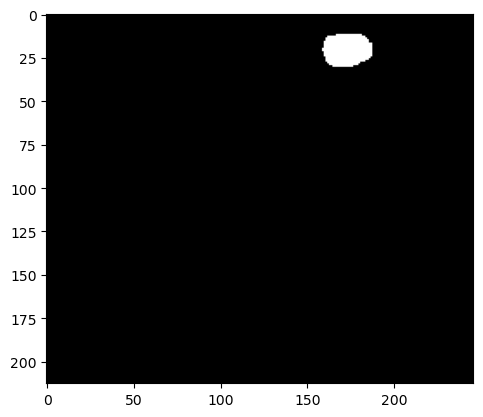

In [113]:
img = sitk.ReadImage('../../Data/Mixed_HGP/per_tumor_lv_mask_+5_07071/CILM_CT_100330_0001.nii.gz')
img_array = sitk.GetArrayFromImage(img)
plt.imshow(img_array[12,:,:], cmap='gray')

In [81]:
row

Sample                  CILM_CT_192810_0000.nii.gz
min_row                                         55
min_col                                        154
min_slice                                      238
max_row                                        158
max_col                                        290
max_slice                                      327
sample                                       19281
tumor_size                                  512200
sample_id                                       67
tumor_id                                         0
row_depth                                      103
col_depth                                      136
slice_depth                                     89
adjusted_min_slice                             238
adjusted_max_slice                             327
lv_min_row                                     NaN
lv_max_row                                     NaN
lv_min_col                                     NaN
lv_max_col                     

In [64]:
row

Sample                  CILM_CT_100330_0000.nii.gz
min_row                                        130
min_col                                        130
min_slice                                      117
max_row                                        141
max_col                                        140
max_slice                                      128
sample                                       10033
tumor_size                                     858
sample_id                                        0
tumor_id                                         0
row_depth                                       11
col_depth                                       10
slice_depth                                     11
adjusted_min_slice                             112
adjusted_max_slice                             133
lv_min_row                                    43.0
lv_max_row                                   288.0
lv_min_col                                    94.0
lv_max_col                     

In [116]:

#### get liver region per tumor
from random import sample
output_folder = '../../Data/Mixed_HGP/per_tumor_lv_+5_07071/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)


for index,row in liver_info.iterrows():
    
   
    
    #out_name = os.path.basename(Mixed_HGP_Data_per_tumor_mask[index])
    #choose largest tumor id'
    sample_id = row['sample_id']
    tumor_id = str(row['tumor_id'])
    out_name = row['Sample'][0:18]+tumor_id+'.nii.gz'
    img_path = Mixed_HGP_Data[sample_id]
    img = sitk.ReadImage(img_path)
    img_array = sitk.GetArrayFromImage(img)
    print('fuck',img_array.sum())

    min_slice,max_slice,min_col,max_col,min_row,max_row = row[['adjusted_min_slice','adjusted_max_slice','lv_min_col','lv_max_col','lv_min_row','lv_max_row']]
    #integer
    min_slice,max_slice,min_col,max_col,min_row,max_row = int(min_slice),int(max_slice),int(min_col),int(max_col),int(min_row),int(max_row)


        #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,max_row,max_col,min_slice,max_slice,'555')
    print(img_array.shape)
    print(out_name)
    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    min_slice = max(0,min_slice)
    max_slice = min(max_slice,img_array.shape[0])
    min_row = max(0,min_row)
    max_row = min(max_row,img_array.shape[2])
    min_col = max(0,min_col)
    max_col = min(max_col,img_array.shape[1])
    #extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    extracted_slices = img_array[min_slice:max_slice+1,min_col:max_col+1, min_row:max_row+1]
    #print('size',extracted_slices.sum())
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    print(output_path,'output save')
    sitk.WriteImage(extracted_img, output_path)
    


fuck -19721972000.0
43 94 288 306 112 133 555
(250, 407, 407)
CILM_CT_100330_0000.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_+5_07071/CILM_CT_100330_0000.nii.gz output save
fuck -19721972000.0
43 94 288 306 130 155 555
(250, 407, 407)
CILM_CT_100330_0001.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_+5_07071/CILM_CT_100330_0001.nii.gz output save
fuck -19721972000.0
43 94 288 306 138 149 555
(250, 407, 407)
CILM_CT_100330_0002.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_+5_07071/CILM_CT_100330_0002.nii.gz output save
fuck -51992936000.0
61 122 314 374 276 293 555
(420, 504, 504)
CILM_CT_100430_0000.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_+5_07071/CILM_CT_100430_0000.nii.gz output save
fuck -51992936000.0
61 122 314 374 356 371 555
(420, 504, 504)
CILM_CT_100430_0001.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_+5_07071/CILM_CT_100430_0001.nii.gz output save
fuck -51992936000.0
61 122 314 374 368 383 555
(420, 504, 504)
CILM_CT_100430_0002.nii.gz
../../Data/Mixed_HGP/per_tumor_lv_+5_07071/CILM_CT_10

In [ ]:


        #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,max_row,max_col,min_slice,max_slice,'555')
    print(img_mask_array.shape)
    print(out_name)
    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    min_slice = max(0,min_slice)
    max_slice = min(max_slice,img_mask_array.shape[0])
    min_row = max(0,min_row)
    max_row = min(max_row,img_mask_array.shape[2])
    min_col = max(0,min_col)
    max_col = min(max_col,img_mask_array.shape[1])
    #extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    extracted_slices = img_mask_array[min_slice:max_slice+1,min_col:max_col+1, min_row:max_row+1]
    #print('size',extracted_slices.sum())
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img_mask.GetSpacing())
    extracted_img.SetDirection(img_mask.GetDirection())
    extracted_img.SetOrigin(img_mask.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    print(output_path,'output save')
    sitk.WriteImage(extracted_img, output_path)
    break


In [ ]:

for index,row in liver_info.iterrows():
    
   
    
    #out_name = os.path.basename(Mixed_HGP_Data_per_tumor_mask[index])
    #choose largest tumor id
    base_path = '../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/'
    largest_tumor_id = str(row['largest_tumor_id'])
    out_name = row['ID'][0:18]+largest_tumor_id+'.nii.gz'
    img_mask = sitk.ReadImage(base_path +out_name)
    img_mask_array = sitk.GetArrayFromImage(img_mask)
    print('fuck',img_mask_array.sum())

    min_slice,max_slice,min_col,max_col,min_row,max_row = row.iloc[1:7] +1
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,max_row,max_col,min_slice,max_slice,'555')
    print(img_mask_array.shape)
    print(out_name)
    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    min_slice = max(0,min_slice)
    max_slice = min(max_slice,img_mask_array.shape[0])
    min_row = max(0,min_row)
    max_row = min(max_row,img_mask_array.shape[2])
    min_col = max(0,min_col)
    max_col = min(max_col,img_mask_array.shape[1])
    #extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    extracted_slices = img_mask_array[min_slice:max_slice+1,min_col:max_col+1, min_row:max_row+1]
    #print('size',extracted_slices.sum())
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img_mask.GetSpacing())
    extracted_img.SetDirection(img_mask.GetDirection())
    extracted_img.SetOrigin(img_mask.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    print(output_path,'output save')
    sitk.WriteImage(extracted_img, output_path)

In [2]:
liver_info = pd.read_csv('../Experiments/data_info/per_tumor_bbx.csv')
liver_info

,Sample,min_row,min_col,min_slice,max_row,max_col,max_slice,sample,tumor_size,sample_id,tumor_id,row_depth,col_depth,slice_depth
0,CILM_CT_100330_0000.nii.gz,130,130,117,141,140,128,10033,858,0,0,11,10,11
1,CILM_CT_100330_0000.nii.gz,202,106,135,230,125,150,10033,5306,0,1,28,19,15
2,CILM_CT_100330_0000.nii.gz,150,127,143,152,129,144,10033,16,0,2,2,2,1
3,CILM_CT_100430_0000.nii.gz,116,288,281,126,296,288,10043,428,1,0,10,8,7
4,CILM_CT_100430_0000.nii.gz,94,249,361,100,254,366,10043,102,1,1,6,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,CILM_CT_975750_0000.nii.gz,186,195,18,197,203,27,97575,695,247,1,11,8,9
877,CILM_CT_994000_0000.nii.gz,191,111,302,203,123,319,99400,1488,248,0,12,12,17
878,CILM_CT_994000_0000.nii.gz,93,205,329,120,227,346,99400,4491,248,1,27,22,17
879,CILM_CT_994000_0000.nii.gz,217,151,338,227,158,349,99400,534,248,2,10,7,11


extract mask for per tumor

In [3]:
output_folder = '../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)


In [4]:
liver_info 

,Sample,min_row,min_col,min_slice,max_row,max_col,max_slice,sample,tumor_size,sample_id,tumor_id,row_depth,col_depth,slice_depth
0,CILM_CT_100330_0000.nii.gz,130,130,117,141,140,128,10033,858,0,0,11,10,11
1,CILM_CT_100330_0000.nii.gz,202,106,135,230,125,150,10033,5306,0,1,28,19,15
2,CILM_CT_100330_0000.nii.gz,150,127,143,152,129,144,10033,16,0,2,2,2,1
3,CILM_CT_100430_0000.nii.gz,116,288,281,126,296,288,10043,428,1,0,10,8,7
4,CILM_CT_100430_0000.nii.gz,94,249,361,100,254,366,10043,102,1,1,6,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,CILM_CT_975750_0000.nii.gz,186,195,18,197,203,27,97575,695,247,1,11,8,9
877,CILM_CT_994000_0000.nii.gz,191,111,302,203,123,319,99400,1488,248,0,12,12,17
878,CILM_CT_994000_0000.nii.gz,93,205,329,120,227,346,99400,4491,248,1,27,22,17
879,CILM_CT_994000_0000.nii.gz,217,151,338,227,158,349,99400,534,248,2,10,7,11


In [22]:
tumor_mask_dic = {}
for index,row in liver_info.iterrows():
    index = row['sample_id']
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    #min_col,min_row,max_col,max_row = liver_bbx_info.iloc[index,1:]
    
    img_array = sitk.GetArrayFromImage(img)
    print('this is image',Mixed_HGP_Data[index])
    file_name = os.path.basename(Mixed_HGP_Data[index])
    print(row['tumor_id'],'this is tumor id')
    #out_name = os.path.basename(Mixed_HGP_Data[index])
    out_name = row['Sample'][0:18] + str(row['tumor_id'])+'.nii.gz'
    #min_row,min_col,min_slice,max_row,max_col,max_slice = row.iloc[1:7] +1

    #liver margin
    #min_col, min_row, max_col, max_row = row.iloc[1:7] +1
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    liver_bbox = LiverBoundingBox(img,None,cropped_out_path,file_name)
    #mask_liver = liver_bbox.extract_liver()
    #liver_bbx = liver_bbox.get_liver_bounding_box(mask_liver)
    #crop the liver
    #liver_slice[file_name] = liver_bbx
    # extract each single tumor
    mask_tumor= liver_bbox.extract_tumor(largest=False)
    #tumor_mask_dic[file_name] = mask_tumor
    #corresponding mask id to tumor id
    mask_id = int(row['tumor_id']) + 1
    print(111)
    output_path = os.path.join(output_folder, out_name)
    print(output_path)
    #extracted_slices = tumor_mask_dic[file_name][mask_id]
    extracted_slices = mask_tumor[mask_id]
    
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    sitk.WriteImage(extracted_img, output_path)
    
    
    


111
../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_266860_0005.nii.gz
this is image c:\Users\098986\Intership_CILM\Data\Mixed_HGP\Mixed_HGP_mask_07071\CILM_CT_266860.nii.gz
6 this is tumor id
111
../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_266860_0006.nii.gz
this is image c:\Users\098986\Intership_CILM\Data\Mixed_HGP\Mixed_HGP_mask_07071\CILM_CT_266860.nii.gz
7 this is tumor id
111
../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_266860_0007.nii.gz
this is image c:\Users\098986\Intership_CILM\Data\Mixed_HGP\Mixed_HGP_mask_07071\CILM_CT_266860.nii.gz
8 this is tumor id
111
../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_266860_0008.nii.gz
this is image c:\Users\098986\Intership_CILM\Data\Mixed_HGP\Mixed_HGP_mask_07071\CILM_CT_267190.nii.gz
0 this is tumor id
111
../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_267190_0000.nii.gz
this is image c:\Users\098986\Intership_CILM\Data\Mixed_HGP\Mixed_HGP_mask_07071\CILM_CT_267190.nii.gz
1 this is tumor id
111
.

In [23]:
img_1 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/CILM_CT_101040.nii.gz')
img_2 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_101040_0003.nii.gz')

img_1_array = sitk.GetArrayFromImage(img_1)
img_2_array = sitk.GetArrayFromImage(img_2)


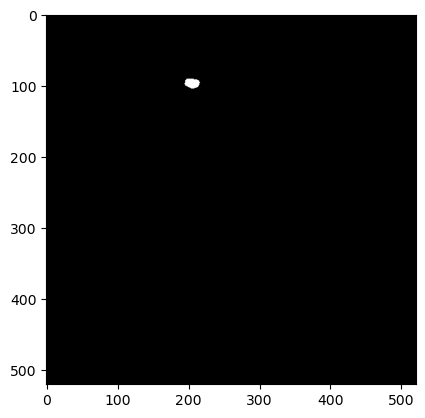

In [25]:
plt.imshow(img_2_array[470,:,:], cmap='gray')

In [93]:
liver_bbx

[61, 94, 43, 237, 306, 288]

In [94]:
file_name_ = 'CILM_CT_168770_0000.nii.gz'
liver_bbx_info

,Unnamed: 0,min_col,min_row,max_col,max_row
0,CILM_CT_100330_0000.nii.gz,94,43,306,288
1,CILM_CT_100430_0000.nii.gz,122,61,374,314
2,CILM_CT_101040_0000.nii.gz,90,62,375,336
3,CILM_CT_102030_0000.nii.gz,93,48,385,353
4,CILM_CT_107020_0000.nii.gz,169,112,440,376
...,...,...,...,...,...
244,CILM_CT_893200_0000.nii.gz,114,37,353,329
245,CILM_CT_941310_0000.nii.gz,92,39,339,272
246,CILM_CT_949120_0000.nii.gz,100,35,353,308
247,CILM_CT_975750_0000.nii.gz,138,101,352,396


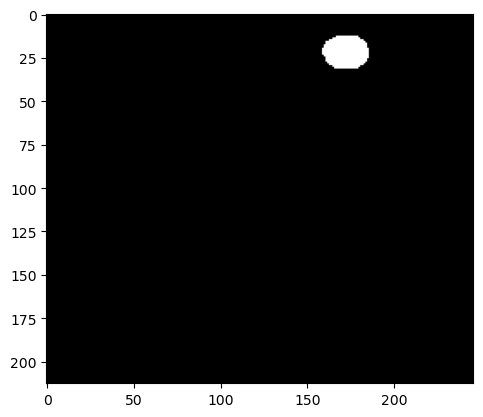

In [64]:
tumor_img = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_100330_0001.nii.gz')
tumor_img = sitk.GetArrayFromImage(tumor_img)
plt.imshow(tumor_img[145,:,:], cmap='gray')

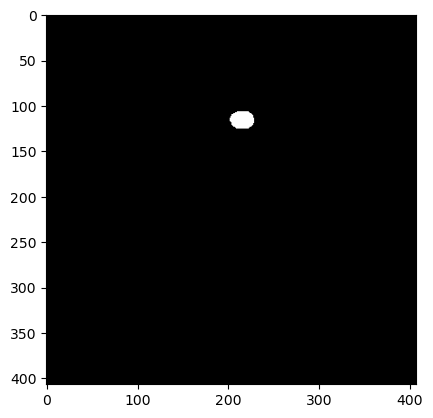

In [46]:
img_mask = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_100330_0001.nii.gz')
img_array = sitk.GetArrayFromImage(img_mask)
plt.imshow(img_array[145,:,:],cmap='gray')

In [45]:
img_array.sum()

5306

In [ ]:

    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    # min_slice = max(0,min_slice)
    # max_slice = min(max_slice,img_array.shape[0])
    # min_row = max(0,min_row)
    # max_row = min(max_row,img_array.shape[2])
    # min_col = max(0,min_col)
    # max_col = min(max_col,img_array.shape[1])
    # extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    mask_id = int(row['tumor_id']) + 1
    tumor_mask = tumor_mask_dic[row['Sample']][mask_id]
    break
    


In [150]:
for i in range(40):
  
    file_name = image_orig_load.images_names[i]
 

    # load the image
    image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    liver_bbox = LiverBoundingBox(image_seg,image_orig,cropped_out_path,file_name)
    mask_liver = liver_bbox.extract_liver()
    liver_bbx = liver_bbox.get_liver_bounding_box(mask_liver)
    #crop the liver
    liver_slice[file_name] = liver_bbx
    # extract each single tumor
    mask_tumor= liver_bbox.extract_tumor(largest=False)
    #tumor_slices = liver_bbox.tumor_bbox(mask_tumor)
    tumor_slice[file_name] = tumor_slices
    tumor_mask_dic[file_name] = mask_tumor
    #get the tumor size
    #tumor_size[file_name] = per_tumor_size(mask_tumor) 
    #tumor bounding box
    #tumor_bbx[file_name] = tumor_bounding_box(mask_tumor,(0,0,0))
    #get non-overlapping slices
    #non_overlapping_slices = select_non_overlapping(tumor_slices)
    #tumor_slice[file_name] = non_overlapping_slices
    

{1: array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

In [ ]:
    output_path = os.path.join(output_folder, out_name)
    
    
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    sitk.WriteImage(extracted_img, output_path)
    break

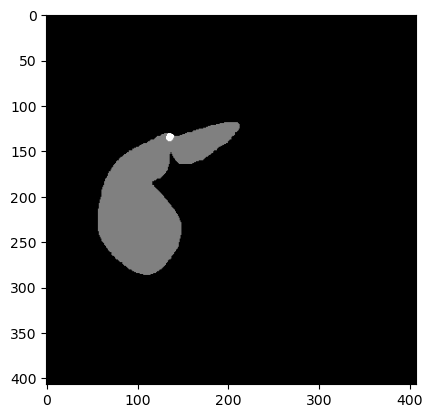

In [14]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
mask = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/CILM_CT_100330.nii.gz')
mask_array = sitk.GetArrayFromImage(mask)

plt.imshow(mask_array[120,:,:],cmap='gray')

In [59]:
y_pred_array.reshape(10,10,2)

ValueError: cannot reshape array of size 100 into shape (10,10,2)

In [51]:
array_stack 

array([[1, 2],
       [1, 2]])

In [21]:
array

array([], dtype=float64)

In [31]:
tumor_slice = {key: [value[0][0],value[0][1]] for key, value in tumor_slice.items()}

In [32]:
df = pd.DataFrame.from_dict(tumor_slice, orient='index', columns=['min_slice', 'max_slice'])


In [36]:
df.to_csv('../../Data/Mixed_HGP/True_Label/largest_tumor_slice.csv')

In [61]:
df

,min_col,min_row,max_col,max_row
CILM_CT_100330_0000.nii.gz,94,43,306,288
CILM_CT_100430_0000.nii.gz,122,61,374,314
CILM_CT_101040_0000.nii.gz,90,62,375,336
CILM_CT_102030_0000.nii.gz,93,48,385,353
CILM_CT_107020_0000.nii.gz,169,112,440,376
...,...,...,...,...
CILM_CT_893200_0000.nii.gz,114,37,353,329
CILM_CT_941310_0000.nii.gz,92,39,339,272
CILM_CT_949120_0000.nii.gz,100,35,353,308
CILM_CT_975750_0000.nii.gz,138,101,352,396


In [84]:
lg = pd.read_csv('../../Data/Mixed_HGP/True_Label/largest_tumor.csv')
df = pd.read_csv('../../Data/Mixed_HGP/liver_bbx.csv')
lg[['min_col','min_row','max_col','max_row']] = df[['min_col','min_row','max_col','max_row']]

In [85]:
lg['col_depth'] = lg['max_col'] - lg['min_col']
lg['row_depth'] = lg['max_row'] - lg['min_row']
lg['slice_depth'] = lg['max_slice'] - lg['min_slice']

In [178]:
img_array = img_array[200:250,:,:]

In [183]:
from email.mime import image
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from monai.transforms import RandSpatialCrop
rand_crop = RandSpatialCrop( roi_size=(64,256, 256), random_center=True)
image_torch = torch.tensor(img_array)
#add two more dimensions
image_torch = image_torch.unsqueeze(0)

In [191]:
lg.to_csv('../../Data/Mixed_HGP/True_Label/largest_tumor.csv',index=False)

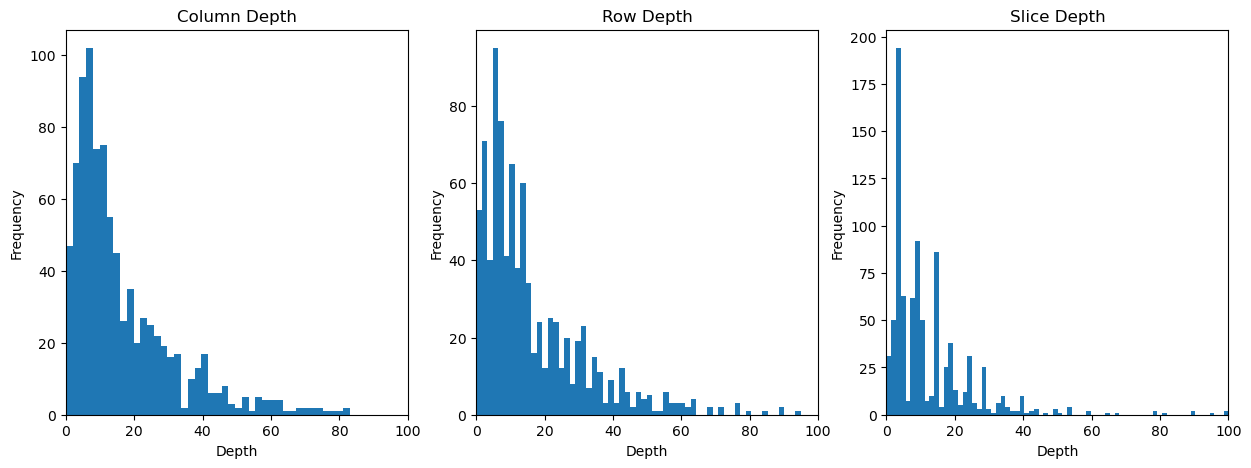

In [11]:
per_tumor = pd.read_csv('../Experiments/data_info/per_tumor_bbx.csv')
#1x3 plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

#plot the histogram
ax[0].hist(per_tumor['col_depth'], bins=100)
ax[0].set_title('Column Depth')
ax[0].set_xlabel('Depth')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 100)

ax[1].hist(per_tumor['row_depth'], bins=100)
ax[1].set_title('Row Depth')
ax[1].set_xlabel('Depth')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 100)

ax[2].hist(per_tumor['slice_depth'], bins=100)
ax[2].set_title('Slice Depth')
ax[2].set_xlabel('Depth')
ax[2].set_ylabel('Frequency')
ax[2].set_xlim(0, 100)

plt.show()

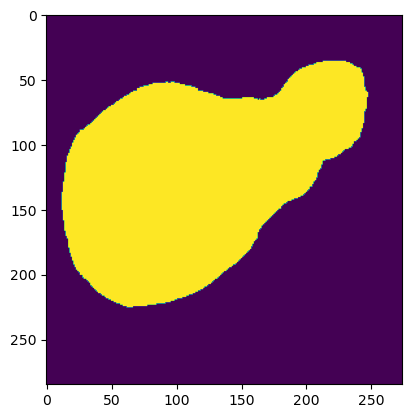

In [57]:
plt.imshow(mask_liver[520,90:375,62:336,])

In [234]:
mask_liver[478,200:220,120:140]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

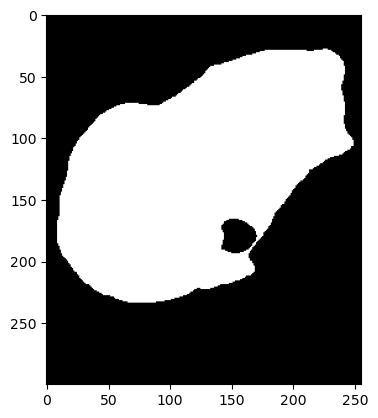

In [275]:
plt.imshow(mask_liver[150,9:309,24:279],cmap='gray')

In [289]:
mask_liver[200,:,:].sum()

0

In [288]:
a = skimage.measure.regionprops(mask_liver[200:337,:,:])

for i in a:
    print(i.bbox)


(28, 109, 63, 137, 292, 276)


In [54]:
tumor_Slice_range = [int(value[0][1])-int(value[0][0]) for value in tumor_slice.values()]

In [60]:
data_frame = pd.DataFrame(generate_sample_ranges(tumor_slice))

In [64]:
data_frame.to_csv('../../Data/Mixed_HGP/True_Label/largest_tumor.csv',index=False)

In [46]:
tumor_Slice_range

[{'ID': 'CILM_CT_100331_0000.nii.gz', 'Min Slice': 135, 'Max Slice': 150},
 {'ID': 'CILM_CT_100431_0000.nii.gz', 'Min Slice': 383, 'Max Slice': 392},
 {'ID': 'CILM_CT_101041_0000.nii.gz', 'Min Slice': 463, 'Max Slice': 477},
 {'ID': 'CILM_CT_102031_0000.nii.gz', 'Min Slice': 293, 'Max Slice': 374},
 {'ID': 'CILM_CT_107021_0000.nii.gz', 'Min Slice': 446, 'Max Slice': 466},
 {'ID': 'CILM_CT_107851_0000.nii.gz', 'Min Slice': 278, 'Max Slice': 377},
 {'ID': 'CILM_CT_108711_0000.nii.gz', 'Min Slice': 448, 'Max Slice': 457},
 {'ID': 'CILM_CT_109291_0000.nii.gz', 'Min Slice': 68, 'Max Slice': 86},
 {'ID': 'CILM_CT_109301_0000.nii.gz', 'Min Slice': 353, 'Max Slice': 373},
 {'ID': 'CILM_CT_109541_0000.nii.gz', 'Min Slice': 16, 'Max Slice': 23},
 {'ID': 'CILM_CT_109631_0000.nii.gz', 'Min Slice': 344, 'Max Slice': 364},
 {'ID': 'CILM_CT_111111_0000.nii.gz', 'Min Slice': 173, 'Max Slice': 192},
 {'ID': 'CILM_CT_111361_0000.nii.gz', 'Min Slice': 425, 'Max Slice': 450},
 {'ID': 'CILM_CT_111551_0000.

In [136]:
a = pd.read_csv('../../Data/Mixed_HGP/True_Label/Largest_Tumor/largest_tumor_+5.csv')
b = pd.read_csv('../../Data/Mixed_HGP/True_Label/Liver_bounding_07071/liver_bbx.csv')
sum(a['max_row'] == b['max_row'])

249

In [46]:
import pandas as pd


# 准备一个空的列表来存放所有行
rows = []

# 遍历字典，将每个肿瘤的范围转换为独立的行
for key, values in tumor_bbx.items():
    for i in range(len(values['min_row'])):
        row = {
            'Sample': key,
            'min_row': values['min_row'][i],
            'min_col': values['min_col'][i],
            'min_slice': values['min_slice'][i],
            'max_row': values['max_row'][i],
            'max_col': values['max_col'][i],
            'max_slice': values['max_slice'][i]
        }
        rows.append(row)

# 创建一个DataFrame
tumor_df = pd.DataFrame(rows)

# 显示DataFrame
print(tumor_df)


                         Sample  min_row  min_col  min_slice  max_row  \
0    CILM_CT_100330_0000.nii.gz      130      130        117      141   
1    CILM_CT_100330_0000.nii.gz      202      106        135      230   
2    CILM_CT_100330_0000.nii.gz      150      127        143      152   
3    CILM_CT_100430_0000.nii.gz      116      288        281      126   
4    CILM_CT_100430_0000.nii.gz       94      249        361      100   
..                          ...      ...      ...        ...      ...   
876  CILM_CT_975750_0000.nii.gz      186      195         18      197   
877  CILM_CT_994000_0000.nii.gz      191      111        302      203   
878  CILM_CT_994000_0000.nii.gz       93      205        329      120   
879  CILM_CT_994000_0000.nii.gz      217      151        338      227   
880  CILM_CT_994000_0000.nii.gz      170      228        347      175   

     max_col  max_slice  
0        140        128  
1        125        150  
2        129        144  
3        296       

In [51]:
tumor_size

{'CILM_CT_100330_0000.nii.gz': [858, 5306, 16],
 'CILM_CT_100430_0000.nii.gz': [428, 102, 148, 206, 174, 1286, 28, 98],
 'CILM_CT_101040_0000.nii.gz': [450, 85, 1160, 2730, 375],
 'CILM_CT_102030_0000.nii.gz': [255592, 556, 3786, 134],
 'CILM_CT_107020_0000.nii.gz': [282,
  24,
  54,
  1791,
  7437,
  2037,
  3045,
  24,
  90,
  303,
  654,
  7692,
  1824,
  81],
 'CILM_CT_107850_0000.nii.gz': [451025, 135, 790],
 'CILM_CT_108710_0000.nii.gz': [251, 482, 204, 587],
 'CILM_CT_109290_0000.nii.gz': [4, 3683, 446, 5165, 753],
 'CILM_CT_109300_0000.nii.gz': [2130, 2442, 336, 2883, 4560],
 'CILM_CT_109540_0000.nii.gz': [284, 89, 9],
 'CILM_CT_109630_0000.nii.gz': [8457],
 'CILM_CT_111110_0000.nii.gz': [150, 1255, 65, 5950, 55],
 'CILM_CT_111360_0000.nii.gz': [66,
  295,
  117,
  32,
  18172,
  3234,
  21,
  722,
  3,
  11615,
  314,
  94,
  89,
  150],
 'CILM_CT_111550_0000.nii.gz': [9360, 2490, 4700, 1040, 18600],
 'CILM_CT_114470_0000.nii.gz': [22716, 11538, 1539, 2703],
 'CILM_CT_116550_0

In [67]:
rows = []

# 遍历字典，为每个tumor size创建一个新行
for sample, sizes in tumor_size.items():
    for size in sizes:
        rows.append({'Sample': sample, 'TumorSize': size})

# 将列表转换为DataFrame
tumor_size_df = pd.DataFrame(rows)

# 显示DataFrame
print(tumor_size_df)

                         Sample  TumorSize
0    CILM_CT_100330_0000.nii.gz        858
1    CILM_CT_100330_0000.nii.gz       5306
2    CILM_CT_100330_0000.nii.gz         16
3    CILM_CT_100430_0000.nii.gz        428
4    CILM_CT_100430_0000.nii.gz        102
..                          ...        ...
876  CILM_CT_975750_0000.nii.gz        695
877  CILM_CT_994000_0000.nii.gz       1488
878  CILM_CT_994000_0000.nii.gz       4491
879  CILM_CT_994000_0000.nii.gz        534
880  CILM_CT_994000_0000.nii.gz         63

[881 rows x 2 columns]


In [68]:
tumor_size_df['Sample'] = tumor_size_df['Sample'].apply(lambda x: x[8:13])

In [79]:
tumor_bbx_df = tumor_df.copy()
tumor_bbx_df['sample'] = tumor_bbx_df['Sample'].apply(lambda x: x[8:13])

In [89]:
tumor_size_df

,sample,TumorSize
0,10033,858
1,10033,5306
2,10033,16
3,10043,428
4,10043,102
...,...,...
876,97575,695
877,99400,1488
878,99400,4491
879,99400,534


In [ ]:
'../Experiments/data_info/'

In [100]:
tumor_bbx_df.to_csv('../Experiments/data_info/per_tumor_bbx.csv')

In [48]:
liver_bounding_info = pd.read_csv('../Experiments/data_info/lagest_tm_liver_bbox.csv')
liver_bounding_info['Sample'] = liver_bounding_info.apply(lambda x: x['Unnamed: 0'][8:13],axis=1)
liver_bounding_info = liver_bounding_info[['min_row','min_col','max_row','max_col','Sample']]
liver_bounding_info['Sample']  = liver_bounding_info['Sample'].astype(int64)

In [50]:
liver_bounding_info

,min_row,min_col,max_row,max_col,Sample
0,118,54,385,362,10033
1,124,62,380,319,10043
2,88,61,369,330,10104
3,93,48,385,353,10203
4,143,95,372,318,10702
...,...,...,...,...,...
244,117,38,364,339,89320
245,100,43,370,297,94131
246,99,35,350,306,94912
247,131,96,334,376,97575


In [52]:
pd.merge(df,liver_bounding_info,on='Sample')



,Sample,MinSlice,MaxSlice,TumorID,min_row,min_col,max_row,max_col
0,10033,117,128,0,118,54,385,362
1,10033,135,150,1,118,54,385,362
2,10033,143,144,2,118,54,385,362
3,10043,281,288,3,124,62,380,319
4,10043,361,366,4,124,62,380,319
...,...,...,...,...,...,...,...,...
876,97575,18,27,876,131,96,334,376
877,99400,302,319,877,115,61,351,347
878,99400,329,346,878,115,61,351,347
879,99400,338,349,879,115,61,351,347


In [58]:
df_merged = df.merge(liver_bounding_info.set_index('Sample'), on='Sample')
df_merged = df_merged.rename(columns={'MinSlice':'min_slice','MaxSlice':'max_slice'})

In [59]:
df_merged

,Sample,min_slice,max_slice,TumorID,min_row,min_col,max_row,max_col
0,10033,117,128,0,118,54,385,362
1,10033,135,150,1,118,54,385,362
2,10033,143,144,2,118,54,385,362
3,10043,281,288,3,124,62,380,319
4,10043,361,366,4,124,62,380,319
...,...,...,...,...,...,...,...,...
876,97575,18,27,876,131,96,334,376
877,99400,302,319,877,115,61,351,347
878,99400,329,346,878,115,61,351,347
879,99400,338,349,879,115,61,351,347


In [62]:
#calculate tumor size
#merged_df_ = pd.read_csv('../Experiments/data_info/merged_per_tumor_size_07071.csv')
merged_df_ = df_merged
image_folder = '../../Data/Mixed_HGP/Mixed_HGP_mask_07071/'

Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]
tumor_sizes = []
for index,row in merged_df_.iterrows():
    index = row['']
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    img_array = sitk.GetArrayFromImage(img)
    
    out_name = os.path.basename(Mixed_HGP_Data[index])
    min_row,min_col,max_row,max_col,min_slice,max_slice = row.loc[:,['min_row','min_col','max_row','max_col','min_slice','max_slice']]
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,min_slice,max_row,max_col,max_slice,'555')
    #when index need to add one more
    extracted_slices = img_array[min_slice:max_slice+1,:,:]
    #set liver to 0
    extracted_slices[extracted_slices == 1] = 0
    per_tumor_size = extracted_slices.sum()
    #print(per_tumor_size)
    tumor_sizes.append(per_tumor_size)
    break
    
    
    

    # 保存提取的切片
    #sitk.WriteImage(extracted_img, output_path)

KeyError: 'sample_id'

In [61]:
row

ID            CILM_CT_100331_0000.nii.gz
Sample                             10033
min_row                              118
min_col                               54
max_row                              385
max_col                              362
Min Slice                            117
Max Slice                            129
sample_id                              0
tumor_size                          1716
depth                                 12
Name: 0, dtype: object

In [71]:
#if overlapping, merge the overlapping slices
merge_overlap_tumor_arange = merge_overlapping_ranges(tumor_slice)

In [72]:
per_tumor_slice = generate_sample_ranges(merge_overlap_tumor_range)
df = pd.DataFrame(per_tumor_slice)
df.to_csv('../Experiments/data_info/per_tumor_merge_overlap',index=False)
#give a label
df['Sample'] = df['ID'].apply(lambda x: x.split('_')[2][0:-1])

In [74]:
#get liver range
liver_range = pd.read_csv('../Experiments/data_info/lagest_tm_liver_bbox.csv')
liver_range['Sample'] = liver_range['Unnamed: 0'].apply(lambda x: x.split('_')[2][0:-1])

In [79]:
#merge liver bounding box and tumor bounding box by sample
merged_df = df.join(liver_range.set_index('Sample'), on='Sample', how='left', lsuffix='_left', rsuffix='_right')

In [81]:
merged_df_ = merged_df[['ID', 'Sample','min_row','min_col','max_row','max_col','Min Slice', 'Max Slice']]

,ID,Min Slice,Max Slice,Sample,Unnamed: 0,min_row,min_col,max_row,max_col,min_slice,max_slice
0,CILM_CT_100331_0000.nii.gz,117,128,10033,CILM_CT_100330_0000.nii.gz,118,54,385,362,68,75
1,CILM_CT_100332_0000.nii.gz,135,150,10033,CILM_CT_100330_0000.nii.gz,118,54,385,362,68,75
2,CILM_CT_100431_0000.nii.gz,281,288,10043,CILM_CT_100430_0000.nii.gz,124,62,380,319,192,196
3,CILM_CT_100432_0000.nii.gz,361,366,10043,CILM_CT_100430_0000.nii.gz,124,62,380,319,192,196
4,CILM_CT_100433_0000.nii.gz,373,378,10043,CILM_CT_100430_0000.nii.gz,124,62,380,319,192,196
...,...,...,...,...,...,...,...,...,...,...,...
594,CILM_CT_949123_0000.nii.gz,143,152,94912,CILM_CT_949120_0000.nii.gz,99,35,350,306,29,30
595,CILM_CT_975751_0000.nii.gz,0,12,97575,CILM_CT_975750_0000.nii.gz,131,96,334,376,0,2
596,CILM_CT_975752_0000.nii.gz,18,27,97575,CILM_CT_975750_0000.nii.gz,131,96,334,376,0,2
597,CILM_CT_994001_0000.nii.gz,302,319,99400,CILM_CT_994000_0000.nii.gz,115,61,351,347,110,115


In [94]:

merged_df_['sample_id'] = pd.factorize(merged_df_['Sample'])[0]


C:\Users\098986\AppData\Local\Temp\ipykernel_23848\41368761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_['sample_id'] = pd.factorize(merged_df_['Sample'])[0]


In [98]:
merged_df_

,ID,Sample,min_row,min_col,max_row,max_col,Min Slice,Max Slice,sample_id,tumor_size
0,CILM_CT_100331_0000.nii.gz,10033,118,54,385,362,117,128,0,0
1,CILM_CT_100332_0000.nii.gz,10033,118,54,385,362,135,150,0,0
2,CILM_CT_100431_0000.nii.gz,10043,124,62,380,319,281,288,1,0
3,CILM_CT_100432_0000.nii.gz,10043,124,62,380,319,361,366,1,0
4,CILM_CT_100433_0000.nii.gz,10043,124,62,380,319,373,378,1,0
...,...,...,...,...,...,...,...,...,...,...
594,CILM_CT_949123_0000.nii.gz,94912,99,35,350,306,143,152,246,0
595,CILM_CT_975751_0000.nii.gz,97575,131,96,334,376,0,12,247,0
596,CILM_CT_975752_0000.nii.gz,97575,131,96,334,376,18,27,247,0
597,CILM_CT_994001_0000.nii.gz,99400,115,61,351,347,302,319,248,0


In [19]:
#calculate tumor size
merged_df_ = pd.read_csv('../Experiments/data_info/merged_per_tumor_size_07071.csv')
image_folder = '../../Data/Mixed_HGP/Mixed_HGP_mask_07071/'

Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]
tumor_sizes = []
for index,row in merged_df_.iterrows():
    index = row['sample_id']
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    img_array = sitk.GetArrayFromImage(img)
    
    out_name = os.path.basename(Mixed_HGP_Data[index])
    min_row,min_col,max_row,max_col,min_slice,max_slice = row.iloc[2:8]
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    #print(min_row,min_col,min_slice,max_row,max_col,max_slice,'555')
    #when index need to add one more
    extracted_slices = img_array[min_slice:max_slice+1,:,:]
    #set liver to 0
    extracted_slices[extracted_slices == 1] = 0
    per_tumor_size = extracted_slices.sum()
    #print(per_tumor_size)
    tumor_sizes.append(per_tumor_size)
    
    
    

    # 保存提取的切片
    #sitk.WriteImage(extracted_img, output_path)

In [25]:
merged_df_.to_csv('../Experiments/data_info/merged_per_tumor_size_07071.csv',index=False)

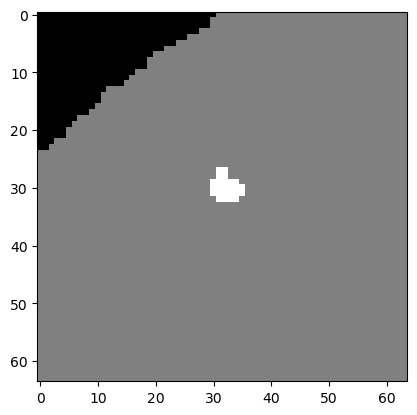

In [37]:
liver_info = pd.read_csv('../Experiments/data_info/per_tumor_bbx_adjusted_64_64_32.csv')
img_1 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/CILM_CT_107020.nii.gz')

img_1_array = sitk.GetArrayFromImage(img_1)
plt.imshow(img_1_array[395,188:252,163:227],cmap='gray')

In [2]:
liver_info_pure = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info.csv')
liver_info_pure.apply(lambda x: x['pHGP']==100 or x['dHGP']==100 or x['rHGP']==100,axis=1)
liver_info_pure = liver_info_pure[liver_info_pure.apply(lambda x: x['pHGP']==100 or x['dHGP']==100 or x['rHGP']==100,axis=1)]

In [54]:
liver_info_pure = liver_info_pure.loc[:,['Experiment','HGP_Type']]
liver_info_pure['sample'] = liver_info_pure['Experiment'].apply(lambda x: x.split('_')[1])
liver_info_pure['sample'] = liver_info_pure['sample'].astype(int)
liver_info_pure = pd.merge(liver_info_pure,liver_info,on='sample')


In [6]:
liver_info_pure.to_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info_pure.csv',index=False)

array([  5,   6,   9,  11,  14,  17,  19,  21,  23,  25,  26,  27,  30,
        31,  32,  35,  36,  38,  40,  43,  47,  48,  49,  51,  53,  57,
        58,  60,  64,  67,  69,  70,  74,  75,  82,  85,  86,  90,  91,
        92,  93,  94,  96,  97,  99, 100, 101, 103, 107, 109, 111, 112,
       116, 121, 122, 123, 124, 126, 128, 131, 132, 133, 138, 140, 141,
       142, 143, 145, 148, 149, 151, 152, 155, 159, 161, 162, 163, 164,
       165, 169, 171, 172, 176, 178, 179, 181, 182, 184, 186, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 201, 202, 204, 206, 208,
       210, 211, 212, 214, 216, 218, 219, 222, 223, 226, 230, 231, 233,
       235, 237, 239, 241, 242, 243, 246, 252, 253, 254, 255, 256, 257,
       258, 261, 262, 263, 264, 267, 268, 270, 272, 274, 275, 278, 283])

In [86]:
from sklearn.model_selection import StratifiedKFold
X = liver_info_pure
y = liver_info_pure['HGP_Type']
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

In [90]:
liver_info_pure.to_csv('../Experiments/data_info/per_tumor_pure_64_64_32.csv',index=False)

In [44]:
liver_info_pure = liver_info_pure['HGP_Type']

HGP_Type
1    52
0    34
Name: count, dtype: int64

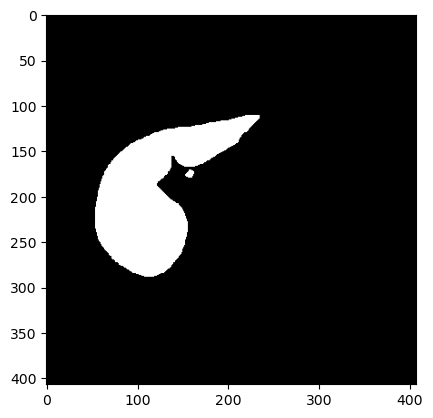

In [32]:
plt.imshow(img_1_array[129,:,:],cmap='gray')

In [144]:
merged_df_['depth'] = merged_df_['Max Slice'] - merged_df_['Min Slice']
merged_df_.to_csv('../Experiments/data_info/merged_per_tumor_size_07071.csv',index=False)

In [25]:
liver_info = pd.read_csv('../Experiments/data_info/per_tumor_bbx.csv')
liver_info.col_depth.median()

11.0

In [44]:
image_probs = skimage.measure.regionprops((mask_liver))

for probs in image_probs:
    bbox = probs.bbox
    min_slice, min_row, min_col, max_slice, max_row, max_col = bbox 
    print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)

    

this is range 0 0 234 472 472 609


In [11]:
liver_bounding = {}
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]
    # load the image
    image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    liver_bbox = LiverBoundingBox(image_seg,image_orig,cropped_out_path,file_name)
    mask_liver = liver_bbox.extract_liver()
    min_row, min_col, _, max_row, max_col, _ = liver_bbox.get_liver_bounding_box(mask_liver)
    liver_bounding[file_name] = (min_row, min_col, max_row, max_col)
    

#mask_tumor[mask_tumor == 2] = 1

(250, 407, 407)
this is range 0 0 62 407 407 250
(420, 504, 504)
this is range 0 0 254 504 504 420
(560, 521, 521)
this is range 0 0 359 521 521 560
(622, 512, 512)
this is range 0 0 226 512 512 622
(714, 606, 606)
this is range 0 0 297 606 606 714
(635, 539, 539)
this is range 0 0 239 539 539 635
(487, 511, 511)
this is range 56 59 337 328 312 483
(368, 485, 485)
this is range 83 36 0 329 318 118
(441, 524, 524)
this is range 0 0 261 524 524 441
(310, 590, 590)
this is range 142 103 0 393 373 61
(462, 539, 539)
this is range 0 0 282 539 539 462
(240, 449, 449)
this is range 0 0 24 449 449 240
(529, 571, 571)
this is range 145 82 349 407 384 509
(625, 449, 449)
this is range 0 0 244 449 449 625
(426, 539, 539)
this is range 0 0 258 539 539 426
(348, 539, 539)
this is range 0 0 0 539 539 348
(190, 472, 472)
this is range 0 0 35 472 472 190
(445, 539, 539)
this is range 0 0 259 539 539 445
(515, 539, 539)
this is range 0 0 299 539 539 515
(525, 577, 577)
this is range 0 0 369 577 577 525

In [12]:
liver_bbox_df = pd.DataFrame.from_dict(liver_bounding,orient='index',columns=['min_row','min_col','max_row','max_col'])
tumor_slice_df = pd.DataFrame.from_dict(tumor_slice,orient='index',columns=['min_slice','max_slice'])
liver_bbox_df = liver_bbox_df.join(tumor_slice_df)


In [13]:
liver_bbox_df['slice_range'] = liver_bbox_df['max_slice'] - liver_bbox_df['min_slice']
liver_bbox_df['row_range'] = liver_bbox_df['max_row'] - liver_bbox_df['min_row']
liver_bbox_df['col_range'] = liver_bbox_df['max_col'] - liver_bbox_df['min_col']
#liver_bbox_df.to_csv('../Experiments/data_info/lagest_tm_liver_bbox.csv')

In [159]:
def get_margin_slice(slice_df, margin_slice=None, margin_percent=0.2):
    slice_df_ = slice_df.copy()
    
    if margin_slice:
        # 计算新的 min_slice 和 max_slice，确保 max_slice 不超过原始 max_slice + margin_slice
        slice_df_['min_slice'] = slice_df_.apply(lambda row: max(0, row['min_slice'] - margin_slice), axis=1)
        slice_df_['max_slice'] = slice_df_.apply(lambda row: min(row['max_slice'] + margin_slice, row['max_slice'] + margin_slice), axis=1)
    else:
        # 根据百分比调整 min_slice 和 max_slice
        slice_df_['min_slice'] = slice_df_['min_slice'] - (slice_df_['min_slice'] * margin_percent).apply(math.floor)
        slice_df_['max_slice'] = slice_df_['max_slice'] + (slice_df_['max_slice'] * margin_percent).apply(math.ceil)
    
    # 更新 slice_range
    slice_df_['slice_range'] = slice_df_['max_slice'] - slice_df_['min_slice']

    return slice_df_

# 使用函数
slice_df_02 = get_margin_slice(liver_bbox_df, margin_slice=10)



In [224]:
#change column position


In [237]:
row

ID           CILM_CT_100331_0000.nii.gz
min_row                             118
min_col                              54
max_row                             385
max_col                             362
min_slice                            59
max_slice                            64
Sample                            10033
Name: 0, dtype: object

In [253]:
merged_df['Index'] = merged_df.groupby('Sample').cumcount()

C:\Users\098986\AppData\Local\Temp\ipykernel_4156\105787752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Index'] = merged_df.groupby('Sample').cumcount()


In [250]:
merged_df.to_csv('../Experiments/data_info/merged_overlap_per_tumor.csv',index=False)

In [75]:
merged_df

NameError: name 'merged_df' is not defined

In [289]:
merged_df['Tumor_name'] = merged_df.apply(lambda x: x['Sample_name'].split('_')[0] + '_' + x['Sample_name'].split('_')[1] + '_' + x['Sample_name'].split('_')[2][0:-1]+ str(x['Sample_Index']) + '_0000.nii.gz')

KeyError: 'Sample_name'

In [297]:
merged_df['Tumor_name'] = merged_df.apply(lambda x: x['Sample_name'].split('_')[0] + '_' + x['Sample_name'].split('_')[1] + '_' + x['Sample_name'].split('_')[2][0:-1]+ str(x['Index']) + '_0000.nii.gz',axis=1)

C:\Users\098986\AppData\Local\Temp\ipykernel_4156\3709222031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Tumor_name'] = merged_df.apply(lambda x: x['Sample_name'].split('_')[0] + '_' + x['Sample_name'].split('_')[1] + '_' + x['Sample_name'].split('_')[2][0:-1]+ str(x['Index']) + '_0000.nii.gz',axis=1)


In [298]:
merged_df.to_csv('../Experiments/data_info/merged_overlap_per_tumor.csv',index=False)

In [120]:
img_rumor = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/CILM_CT_100330_0000.nii.gz')
img_rumor_array = sitk.GetArrayFromImage(img_rumor)
img_rumor_array.shape

(250, 213, 246)

In [144]:
per_tumor_info = pd.read_csv('../Experiments/data_info/per_tumor_bbx.csv')
# Group by 'sample_id' and find the entry with the maximum 'tumor_size' for each group
max_tumor_size_df = per_tumor_info.loc[per_tumor_info.groupby('sample_id')['tumor_size'].idxmax()]
max_tumor_size_df.reset_index(drop=True, inplace=True)
# Display the DataFrame with max 'tumor_size' per 'sample_id'
liver_info['largest_tumor_id'] = max_tumor_size_df['tumor_id']


In [150]:
liver_info.to_csv('../../Data/Mixed_HGP/True_Label/Largest_Tumor/largest_tumor_+5.csv',index=False)

In [77]:
import os
image_folder = '../../Data/Mixed_HGP/Mixed_HGP_07071/'
image_folder_mask = '../../Data/Mixed_HGP/Mixed_HGP_mask_07071/'

image_folder_per_tumor_mask = '../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/'

Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_07071/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]

Mixed_HGP_Data_mask = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/')
Mixed_HGP_Data_mask = [os.path.abspath(os.path.join(image_folder_mask, f)) for f in os.listdir(image_folder_mask)]

Mixed_HGP_Data_per_tumor_mask = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/')
Mixed_HGP_Data_per_tumor_mask = [os.path.abspath(os.path.join(image_folder_per_tumor_mask, f)) for f in os.listdir(image_folder_per_tumor_mask)]
output_folder = '../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)


#get bounding info 
liver_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/Largest_Tumor/largest_tumor_+5.csv')
#for mask

for index,row in liver_info.iterrows():
    
   
    
    #out_name = os.path.basename(Mixed_HGP_Data_per_tumor_mask[index])
    #choose largest tumor id
    base_path = '../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/'
    largest_tumor_id = str(row['largest_tumor_id'])
    out_name = row['ID'][0:18]+largest_tumor_id+'.nii.gz'
    img_mask = sitk.ReadImage(base_path +out_name)
    img_mask_array = sitk.GetArrayFromImage(img_mask)
    print('fuck',img_mask_array.sum())

    min_slice,max_slice,min_col,max_col,min_row,max_row = row.iloc[1:7] +1
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,max_row,max_col,min_slice,max_slice,'555')
    print(img_mask_array.shape)
    print(out_name)
    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    min_slice = max(0,min_slice)
    max_slice = min(max_slice,img_mask_array.shape[0])
    min_row = max(0,min_row)
    max_row = min(max_row,img_mask_array.shape[2])
    min_col = max(0,min_col)
    max_col = min(max_col,img_mask_array.shape[1])
    #extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    extracted_slices = img_mask_array[min_slice:max_slice+1,min_col:max_col+1, min_row:max_row+1]
    #print('size',extracted_slices.sum())
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img_mask.GetSpacing())
    extracted_img.SetDirection(img_mask.GetDirection())
    extracted_img.SetOrigin(img_mask.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    print(output_path,'output save')
    sitk.WriteImage(extracted_img, output_path)

In [78]:
#for mask

for index,row in liver_info.iterrows():
    
   
    
    #out_name = os.path.basename(Mixed_HGP_Data_per_tumor_mask[index])
    #choose largest tumor id
    base_path = '../../Data/Mixed_HGP/Mixed_HGP_Per_tumor_mask/'
    largest_tumor_id = str(row['largest_tumor_id'])
    out_name = row['ID'][0:18]+largest_tumor_id+'.nii.gz'
    img_mask = sitk.ReadImage(base_path +out_name)
    img_mask_array = sitk.GetArrayFromImage(img_mask)
    print('fuck',img_mask_array.sum())

    min_slice,max_slice,min_col,max_col,min_row,max_row = row.iloc[1:7] +1
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,max_row,max_col,min_slice,max_slice,'555')
    print(img_mask_array.shape)
    print(out_name)
    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    min_slice = max(0,min_slice)
    max_slice = min(max_slice,img_mask_array.shape[0])
    min_row = max(0,min_row)
    max_row = min(max_row,img_mask_array.shape[2])
    min_col = max(0,min_col)
    max_col = min(max_col,img_mask_array.shape[1])
    #extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    extracted_slices = img_mask_array[min_slice:max_slice+1,min_col:max_col+1, min_row:max_row+1]
    #print('size',extracted_slices.sum())
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img_mask.GetSpacing())
    extracted_img.SetDirection(img_mask.GetDirection())
    extracted_img.SetOrigin(img_mask.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    print(output_path,'output save')
    sitk.WriteImage(extracted_img, output_path)
    

fuck 5306
44 95 289 307 131 156 555
(250, 407, 407)
CILM_CT_100330_0001.nii.gz
../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_100330_0001.nii.gz output save
fuck 1286
62 123 315 375 379 398 555
(420, 504, 504)
CILM_CT_100430_0005.nii.gz
../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_100430_0005.nii.gz output save
fuck 2730
63 91 337 376 459 483 555
(560, 521, 521)
CILM_CT_101040_0003.nii.gz
../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_101040_0003.nii.gz output save
fuck 255592
49 94 354 386 294 375 555
(622, 512, 512)
CILM_CT_102030_0000.nii.gz
../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_102030_0000.nii.gz output save
fuck 7692
113 170 377 441 447 467 555
(714, 606, 606)
CILM_CT_107020_00011.nii.gz
../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_107020_00011.nii.gz output save
fuck 451025
107 148 401 353 279 378 555
(635, 539, 539)
CILM_CT_107850_0000.nii.gz
../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_107850_0000.

In [43]:
img_mask_array.sum()

2730

In [63]:
img_mask_array.shape,img_array.shape

((25, 286, 275), (24, 285, 274))

Text(0, 0.5, 'Height')

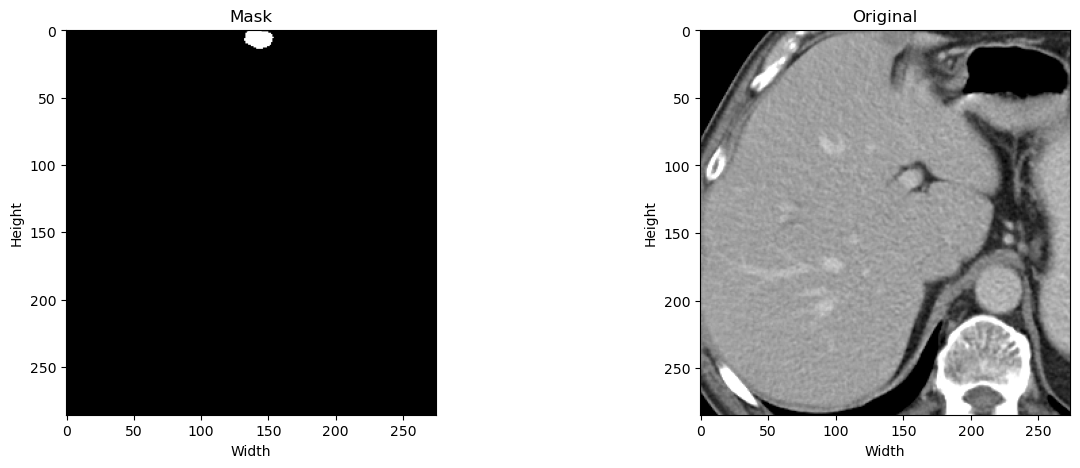

In [58]:
img_mask = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_101040_0003.nii.gz')
img_mask_array = sitk.GetArrayFromImage(img_mask)
img = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_+5//CILM_CT_101040_0000.nii.gz')
img_array = sitk.GetArrayFromImage(img)

#1x2 plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#plot slice
ax[0].imshow(img_mask_array[10,:,:], cmap='gray')
ax[0].set_title('Mask')
ax[0].set_xlabel('Width')
ax[0].set_ylabel('Height')

ax[1].imshow(img_array[10,:,:], cmap='gray')
ax[1].set_title('Original')
ax[1].set_xlabel('Width')
ax[1].set_ylabel('Height')


In [70]:
img_mask = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_100430_0005.nii.gz')
img_mask_array = sitk.GetArrayFromImage(img_mask)
img_mask_array.shape

(20, 253, 254)

In [64]:
liver_info

,ID,min_slice,max_slice,min_col,max_col,min_row,max_row,col_depth,row_depth,slice_depth,largest_tumor_id
0,CILM_CT_100330_0000.nii.gz,130,155,94,306,43,288,212,245,25,1
1,CILM_CT_100430_0000.nii.gz,378,397,122,374,61,314,252,253,19,5
2,CILM_CT_101040_0000.nii.gz,458,482,90,375,62,336,285,274,24,3
3,CILM_CT_102030_0000.nii.gz,293,374,93,385,48,353,292,305,81,0
4,CILM_CT_107020_0000.nii.gz,446,466,169,440,112,376,271,264,20,11
...,...,...,...,...,...,...,...,...,...,...,...
244,CILM_CT_893200_0000.nii.gz,290,308,114,353,37,329,239,292,18,0
245,CILM_CT_941310_0000.nii.gz,327,342,92,339,39,272,247,233,15,1
246,CILM_CT_949120_0000.nii.gz,138,157,100,353,35,308,253,273,19,2
247,CILM_CT_975750_0000.nii.gz,0,17,138,352,101,396,214,295,17,0


In [67]:
output_folder = '../../Data/Mixed_HGP/largest_tm_lv_slices_+5/'

In [68]:

for index,row in liver_info.iterrows():
    #index = row['sample_id']
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    #img = sitk.ReadImage(Mixed_HGP_Data[index])
    img_array = sitk.GetArrayFromImage(img)

    out_name = os.path.basename(Mixed_HGP_Data[index])

   
   
    min_slice,max_slice,min_col,max_col,min_row,max_row = row.iloc[1:7] +1
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,max_row,max_col,min_slice,max_slice,'555')
    print(img_array.shape)
    #if (min_slice == max_slice) or (max_slice - min_slice < 3):
    #    max_slice = min(max_slice + 3, img_array.shape[0])
    #boundary
    min_slice = max(0,min_slice)
    max_slice = min(max_slice,img_array.shape[0])
    min_row = max(0,min_row)
    max_row = min(max_row,img_array.shape[2])
    min_col = max(0,min_col)
    max_col = min(max_col,img_array.shape[1])
    extracted_slices = img_array[min_slice:max_slice+1,min_col:max_col+1, min_row:max_row+1]
    #extracted_slices = img_array[min_slice:max_slice,:,:]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())
    sitk.GetArrayFromImage(extracted_img).shape
    sitk.WriteImage(extracted_img, output_path)
    
    


40 58 285 275 84 103 555
(200, 453, 453)
79 145 379 425 439 478 555
(530, 613, 613)
139 68 363 327 402 442 555
(483, 420, 650)
26 112 302 326 54 69 555
(351, 416, 416)
78 119 362 400 396 413 555
(454, 582, 582)
44 103 298 370 409 433 555
(620, 503, 503)
32 78 362 323 345 386 555
(447, 459, 459)
50 132 291 339 159 208 555
(415, 449, 449)
76 166 402 436 412 429 555
(456, 612, 612)
65 165 373 392 34 58 555
(335, 539, 539)
72 122 335 335 99 131 555
(201, 507, 507)
58 115 368 324 34 133 555
(185, 461, 461)
60 141 381 356 335 354 555
(452, 475, 475)
101 184 367 388 385 406 555
(431, 583, 583)
50 116 310 380 67 86 555
(184, 499, 499)
70 145 379 377 1 8 555
(296, 499, 499)
19 67 276 351 349 363 555
(430, 472, 472)
38 67 303 352 104 128 555
(390, 449, 449)
49 119 368 325 394 423 555
(655, 472, 472)
72 102 287 322 218 243 555
(628, 505, 505)
59 128 302 409 79 103 555
(175, 539, 539)
24 65 303 330 1 35 555
(298, 427, 427)
83 136 352 341 334 358 555
(695, 546, 546)
89 143 337 396 466 487 555
(507,

In [113]:
img_mask = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5//CILM_CT_100330.nii.gz')
img_array = sitk.GetArrayFromImage(img_mask)

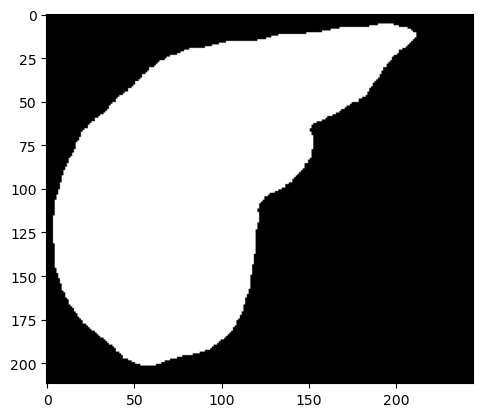

In [116]:
plt.imshow(img_array[20,:,:],cmap='gray')
    

In [97]:
output_path


'../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_100330_0000.nii.gz'

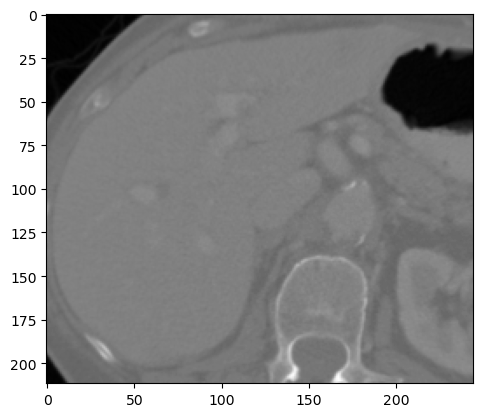

In [88]:
img_mask = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5//CILM_CT_100330_0000.nii.gz')

img_array = sitk.GetArrayFromImage(img_mask)
plt.imshow(img_array[2,:,:], cmap='gray')

In [95]:
img_mask_array.shape

(250, 407, 407)

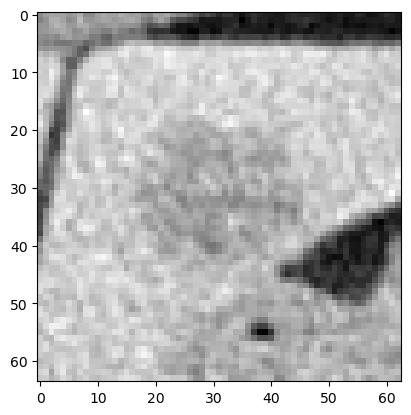

In [7]:
import SimpleITK as sitk
img = sitk.ReadImage('../../Data/Mixed_HGP/Per_tumor_bbx_64_64_32/CILM_CT_107020_0004.nii.gz')
img_array = sitk.GetArrayFromImage(img)
img_raw = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_07071/CILM_CT_100330_0000.nii.gz')
img_array_raw = sitk.GetArrayFromImage(img_raw)
plt.imshow(img_array[14,:,:],cmap='gray')
#plt.imshow(img_array_raw[150,102:129,196:236],cmap='gray')

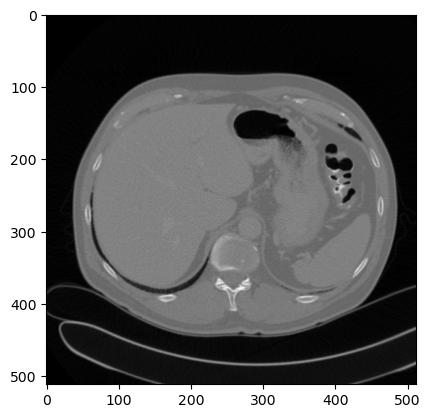

In [319]:
fault_otigin = sitk.ReadImage('../../Data/Mixed_HGP/overlaped_per_tumor/CILM_CT_100431_0000.nii.gz')
plt.imshow(sitk.GetArrayFromImage(fault_otigin)[0,:,:],cmap='gray')

In [306]:
fault_otigin.GetOrigin()

(-214.48797607421875, -80.411376953125, 17.5)

In [122]:
import numpy as np
# Windowing
def apply_window_to_volume(batched_volumes, window_center, window_width):
    """
    Apply windowing to a batch of 3D volumes.
    :param batched_volumes: The input batch of 3D volumes.
    :param window_center: The center of the window (window level).
    :param window_width: The width of the window.
    :return: Windowed batch of 3D volumes.
    """
    lower_bound = window_center - window_width / 2
    upper_bound = window_center + window_width / 2
    windowed_batched_volumes = np.clip(batched_volumes, lower_bound, upper_bound)
    return windowed_batched_volumes

windowed_imgs = os.listdir('../../Data/Mixed_HGP/per_tumor_lv_+5_07071/')
windowed_imgs = [os.path.abspath(os.path.join('../../Data/Mixed_HGP/per_tumor_lv_+5_07071//',f)) for f in os.listdir('../../Data/Mixed_HGP/per_tumor_lv_+5_07071//')]

output_folder = '../../Data/Mixed_HGP/per_tumor_lv_+5_07071_window/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [83]:
img = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_+5/CILM_CT_893200_0000.nii.gz')
img_array = sitk.GetArrayFromImage(img)
img_2 = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_mask_+5/CILM_CT_893200_0000.nii.gz')
img_array_2 = sitk.GetArrayFromImage(img_2)

img_array_2.shape,img_array.shape

((19, 240, 293), (19, 240, 293))

In [123]:

for index,img in enumerate(windowed_imgs):
    image = sitk.ReadImage(img)
    image_array = sitk.GetArrayFromImage(image)
    out_name = os.path.basename(img)
    output_path = os.path.join(output_folder, out_name)

    #windowed_image = apply_window_to_volume(image_array, 50, 400)
    windowed_image = apply_window_to_volume(image_array,50,400)
    
    
    windowed_image = sitk.GetImageFromArray(windowed_image)
    windowed_image.SetSpacing(image.GetSpacing())
    windowed_image.SetDirection(image.GetDirection())
    windowed_image.SetOrigin(image.GetOrigin())
    sitk.WriteImage(windowed_image, output_path)

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:102:
sitk::ERROR: Unable to open "c:\Users\098986\Intership_CILM\Data\Mixed_HGP\per_tumor_lv_+5_07071\_window" for reading.

In [4]:
len(os.listdir('../../Data/Mixed_HGP/largest_tm_lv_slices_window_+5/'))

249

In [74]:
img = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_+5/CILM_CT_107850_0000.nii.gz')
img_array = sitk.GetArrayFromImage(img)
plt.imshow(img_array[20,:,:],cmap='gray')

IndexError: index 20 is out of bounds for axis 0 with size 20

In [27]:
img = sitk.ReadImage('../../Data/Mixed_HGP/Per_tumor_bbx_64_64_32/CILM_CT_100330_0000.nii.gz')
img_array_no = sitk.GetArrayFromImage(img)

In [111]:
import torch

a = torch.rand(1,4,5,4,4)

torch.nn.Dropout3d(0.5)(a)[0,2,:,:,:]

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [ ]:
#statistic the size of the image
image_folder = '../../Data/Mixed_HGP/largest_tm_lv_07071_windowed_+20/'
Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/largest_tm_lv_07071_windowed_+20/')
Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]

for index,img in enumerate(Mixed_HGP_Data):
    image = sitk.ReadImage(img)
    image_array = sitk.GetArrayFromImage(image)
    print(image_array.shape)

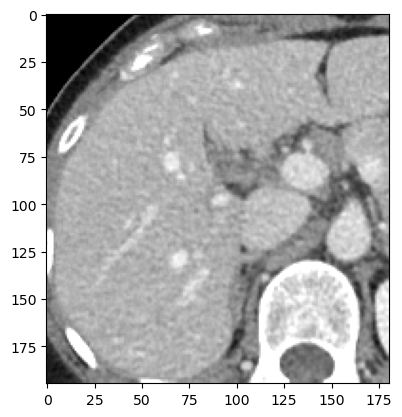

In [244]:
test_img = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_07071_windowed_+20/CILM_CT_323410_0000.nii.gz')
test_img_array = sitk.GetArrayFromImage(test_img)
plt.imshow(test_img_array[0,:,:],cmap='gray')

(array([55., 80., 43., 15., 12., 13., 10.,  4.,  4.,  3.,  1.,  4.,  3.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 0.  ,  3.35,  6.7 , 10.05, 13.4 , 16.75, 20.1 , 23.45, 26.8 ,
        30.15, 33.5 , 36.85, 40.2 , 43.55, 46.9 , 50.25, 53.6 , 56.95,
        60.3 , 63.65, 67.  ]),
 <BarContainer object of 20 artists>)

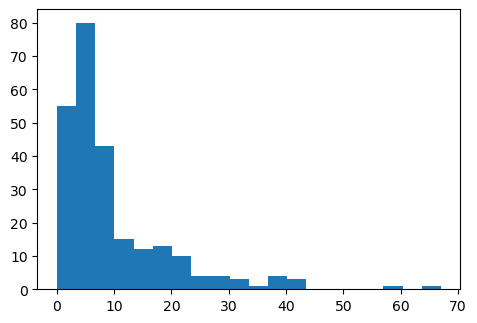

In [96]:
#plot 
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.hist(liver_bbox_df['slice_range'],bins=20)


# Extract tumore


In [108]:
#tumor slices with liver bounding box
liver_bounding = {'min_row': [], 'min_col': [], 'max_row': [], 'max_col': []}

In [109]:
mask_1 = sitk.ReadImage('../../Data/Mixed_HGP/Mxied_HGP_mask/CILM_CT_100330.nii.gz')
mask_1_array = sitk.GetArrayFromImage(mask_1)
cropped_out_path = '../../Data/Mixed_HGP/largest_tm_lv_bbox/'
os.mkdir(cropped_out_path)
#load the images
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_Raw/")
image_seg_load = ImageLoad("../../Data/Mixed_HGP/Mxied_HGP_mask/")
tumor_slices = []
# get the image names
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]

    # load the image
    image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    liver_bbox = LiverBoundingBox(image_seg,image_orig,cropped_out_path,file_name)
    mask_tumor_0 = liver_bbox.extract_liver(liver=True,no_connection=True)
    min_slice,max_slice = liver_tumore_info.iloc[i,:]['min_slice'],liver_tumore_info.iloc[i,:]['max_slice']
    mask_tumor_0 = mask_tumor_0[min_slice:max_slice,:,:]
    print(mask_tumor_0.shape,'shit')
    image_probs = skimage.measure.regionprops((mask_tumor_0))

    # get the bounding box of the liver
    for probs in image_probs:
        bbox = probs.bbox
        min_slice, min_row, min_col, max_slice, max_row, max_col = bbox 
        print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)
        liver_bounding['min_row'].append(min_row)
        liver_bounding['min_col'].append(min_col)
        liver_bounding['max_row'].append(max_row)
        liver_bounding['max_col'].append(max_col)
    
        
    #
    """
    tumor_bbox = liver_bbox.tumor_bbox(mask_tumor)
    min_row, min_col, min_slice, max_row, max_col, max_slice = tumor_bbox
    with open('../../Data/Mixed_HGP/Mixed_HGP_Tumor_Bbox.txt','a') as f:
        f.write(file_name + ',' + str(min_row) + ',' + str(min_col) + ',' + str(min_slice) + ',' + str(max_row) + ',' + str(max_col) + ',' + str(max_slice) + '\n')
    """


(125, 512, 512)
(18, 512, 512) shit
this is range 128 61 0 372 320 18
(210, 512, 512)
(63, 512, 512) shit
this is range 124 62 0 380 319 63
(112, 512, 512)
(22, 512, 512) shit
this is range 88 61 0 369 330 22
(311, 512, 512)
(48, 512, 512) shit
this is range 93 48 0 385 353 48
(238, 512, 512)
(48, 512, 512) shit
this is range 143 95 0 372 318 48
(127, 512, 512)
(21, 512, 512) shit
this is range 140 101 0 335 380 21
(487, 512, 512)
(115, 512, 512) shit
this is range 56 59 0 329 314 115
(307, 512, 512)
(32, 512, 512) shit
this is range 87 38 0 347 307 32
(147, 512, 512)
(22, 512, 512) shit
this is range 148 80 0 373 325 22
(207, 512, 512)
(28, 512, 512) shit
this is range 125 91 0 341 324 28
(154, 512, 512)
(8, 512, 512) shit
this is range 136 70 0 374 203 8
(48, 512, 512)
(33, 512, 512) shit
this is range 93 46 0 372 387 33
(529, 512, 512)
(110, 512, 512) shit
this is range 130 73 0 365 345 110
(125, 512, 512)
(16, 512, 512) shit
this is range 138 43 0 387 328 16
(142, 512, 512)
(23, 51

In [93]:
image_folder = '../../Data/Mixed_HGP/Mixed_HGP_Raw/'


Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Raw/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]
output_folder = '../../Data/Mixed_HGP/tm_slices_lv_region_+3/'
for index,row in liver_info.iterrows():
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    img_array = sitk.GetArrayFromImage(img)
    out_name = os.path.basename(Mixed_HGP_Data[index])
    min_row,min_col,min_slice,max_row,max_col,max_slice = row.iloc[1:7]
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,min_slice,max_row,max_col,max_slice,'555')
    extracted_slices = img_array[min_slice:max_slice,min_row:max_row, min_col:max_col]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())

    # 保存提取的切片
    sitk.WriteImage(extracted_img, output_path)

NameError: name 'liver_info' is not defined

In [28]:
liver_info = pd.read_csv('c:/Users/098986/Intership_CILM/Data/Mixed_HGP/True_Label/scans_used_all_info.csv')
liver_info = liver_info.loc[:,['Experiment','HGP_Type']]

merged_df = pd.read_csv('../Experiments/data_info/merged_per_tumor_size_07071.csv')


In [ ]:
#calculate linear corralation with tumor size and depth


Text(0.5, 1.0, 'Tumor Size Distribution')

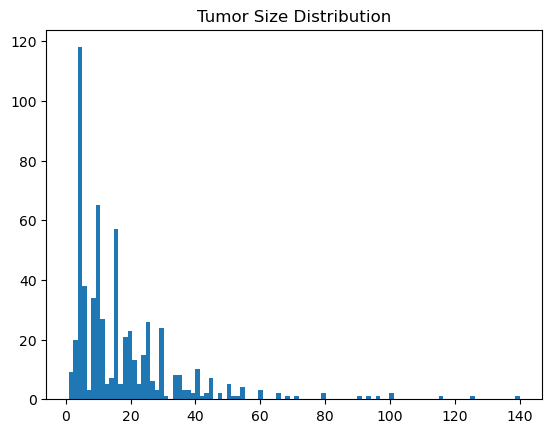

In [32]:
plt.hist(merged_df['depth'],bins=100)
plt.title('Tumor Size Distribution')

Text(0.5, 1.0, 'Tumor Depth Distribution--0.25 Quantile')

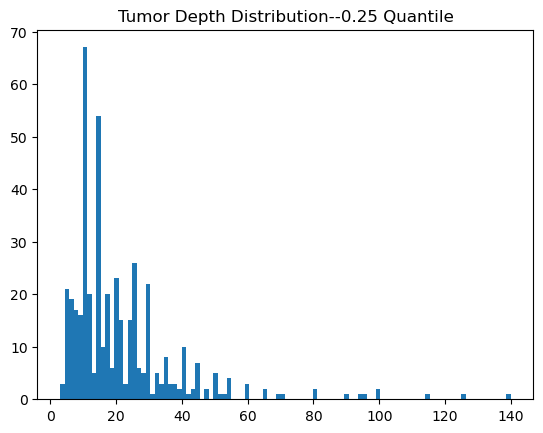

In [30]:
#0.25 quantile
quanti_25 = merged_df['tumor_size'].quantile(0.25)
quantile_df = merged_df[merged_df['tumor_size'] > quanti_25]
#plot depth
plt.hist(quantile_df['depth'], bins=100)
plt.title('Tumor Depth Distribution--0.25 Quantile ')

In [39]:
merged_df['depth'].quantile(0.25)

6.0

: 

In [36]:
quantile_df['depth'].quantile(0.25)

10.0

In [7]:
merged_df

,ID,Sample,min_row,min_col,max_row,max_col,Min Slice,Max Slice,sample_id,tumor_size,depth
0,CILM_CT_100331_0000.nii.gz,10033,118,54,385,362,117,128,0,1716,11
1,CILM_CT_100332_0000.nii.gz,10033,118,54,385,362,135,150,0,10644,15
2,CILM_CT_100431_0000.nii.gz,10043,124,62,380,319,281,288,1,856,7
3,CILM_CT_100432_0000.nii.gz,10043,124,62,380,319,361,366,1,204,5
4,CILM_CT_100433_0000.nii.gz,10043,124,62,380,319,373,378,1,296,5
...,...,...,...,...,...,...,...,...,...,...,...
594,CILM_CT_949123_0000.nii.gz,94912,99,35,350,306,143,152,246,2810,9
595,CILM_CT_975751_0000.nii.gz,97575,131,96,334,376,0,12,247,10258,12
596,CILM_CT_975752_0000.nii.gz,97575,131,96,334,376,18,27,247,1390,9
597,CILM_CT_994001_0000.nii.gz,99400,115,61,351,347,302,319,248,2976,17


In [35]:
merged_df['Sample'] = merged_df['Sample'].apply(lambda x: 'CT_' + str(x))

In [14]:
merged_df

,min_row,min_col,max_row,max_col,min_slice,max_slice,Sample,Sample_name,Index,Sample_Index,Tumor_name,Experiment_x,HGP_Type_x,Experiment_y,HGP_Type_y,Experiment,HGP_Type
0,118,54,385,362,59,64,CT_10033,CILM_CT_100330_0000.nii.gz,0,0,CILM_CT_100330_0000.nii.gz,CT_10033,0,CT_10033,0,CT_10033,0
1,118,54,385,362,68,75,CT_10033,CILM_CT_100330_0000.nii.gz,1,0,CILM_CT_100331_0000.nii.gz,CT_10033,0,CT_10033,0,CT_10033,0
2,124,62,380,319,141,144,CT_10043,CILM_CT_100430_0000.nii.gz,0,1,CILM_CT_100430_0000.nii.gz,CT_10043,0,CT_10043,0,CT_10043,0
3,124,62,380,319,181,183,CT_10043,CILM_CT_100430_0000.nii.gz,1,1,CILM_CT_100431_0000.nii.gz,CT_10043,0,CT_10043,0,CT_10043,0
4,124,62,380,319,187,189,CT_10043,CILM_CT_100430_0000.nii.gz,2,1,CILM_CT_100432_0000.nii.gz,CT_10043,0,CT_10043,0,CT_10043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,99,35,350,306,29,30,CT_94912,CILM_CT_949120_0000.nii.gz,2,246,CILM_CT_949122_0000.nii.gz,CT_94912,1,CT_94912,1,CT_94912,1
595,131,96,334,376,0,2,CT_97575,CILM_CT_975750_0000.nii.gz,0,247,CILM_CT_975750_0000.nii.gz,CT_97575,1,CT_97575,1,CT_97575,1
596,131,96,334,376,4,5,CT_97575,CILM_CT_975750_0000.nii.gz,1,247,CILM_CT_975751_0000.nii.gz,CT_97575,1,CT_97575,1,CT_97575,1
597,115,61,351,347,101,106,CT_99400,CILM_CT_994000_0000.nii.gz,0,248,CILM_CT_994000_0000.nii.gz,CT_99400,1,CT_99400,1,CT_99400,1


In [36]:
merged_df = pd.merge(merged_df,liver_info,left_on='Sample',right_on='Experiment',how='left')


In [37]:

merged_df.drop(columns='Experiment',inplace=True)

In [38]:
from collections import Counter
Counter(merged_df.HGP_Type)

Counter({0: 481, 1: 118})

In [39]:
merged_df

,ID,Sample,min_row,min_col,max_row,max_col,Min Slice,Max Slice,sample_id,tumor_size,depth,HGP_Type
0,CILM_CT_100331_0000.nii.gz,CT_10033,118,54,385,362,117,128,0,1716,11,0
1,CILM_CT_100332_0000.nii.gz,CT_10033,118,54,385,362,135,150,0,10644,15,0
2,CILM_CT_100431_0000.nii.gz,CT_10043,124,62,380,319,281,288,1,856,7,0
3,CILM_CT_100432_0000.nii.gz,CT_10043,124,62,380,319,361,366,1,204,5,0
4,CILM_CT_100433_0000.nii.gz,CT_10043,124,62,380,319,373,378,1,296,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
594,CILM_CT_949123_0000.nii.gz,CT_94912,99,35,350,306,143,152,246,2810,9,1
595,CILM_CT_975751_0000.nii.gz,CT_97575,131,96,334,376,0,12,247,10258,12,1
596,CILM_CT_975752_0000.nii.gz,CT_97575,131,96,334,376,18,27,247,1390,9,1
597,CILM_CT_994001_0000.nii.gz,CT_99400,115,61,351,347,302,319,248,2976,17,1


In [48]:
a = merged_df[merged_df['tumor_size']>400]
Counter(a.HGP_Type)

Counter({0: 364, 1: 91})

# Tumor plot

In [1]:
import pandas as pd
import SimpleITK as sitk
import os

C:\Users\098986\AppData\Local\Temp\ipykernel_24472\3075030410.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [21]:
mask_path = '../../Data/Mixed_HGP/Mxied_HGP_mask/'
mask_names = os.listdir(mask_path)
mask_names = [os.path.abspath(os.path.join(mask_path, f)) for f in os.listdir(mask_path)]
mask_names.sort()
tumor_size_per_patient = {}
#get per tumor in each image
class Pertumor(LiverBoundingBox):
    def __init__(self,liver_mask,liver_orig,out_path_box=None,file_name=None):
        """
        args:
            liver_mask: the liver mask|nib or sitk
            original_image: the original image|nib or sitk
        """
        self.liver_seg = liver_mask
        self.liver_orig = liver_orig
        self.out_path_box = out_path_box
        self.file_name = file_name
    
    def extract_tumor(self):
        mask = self._get_array(self.liver_seg)
        mask = mask.astype(int)
        print(mask.shape)

        mask[mask == 1] = 0
        mask[mask == 2] = 1
        mask = mask.astype(int)

        #get connected component
        labeled,num_features = skimage.measure.label(mask, connectivity=2,return_num=True)
        print(num_features,'num_features')
        #record the size of each tumor
        tumor_size = []
        #for every tumor
        for label in range(1, num_features + 1):
            label_size = np.sum(labeled == label)
            tumor_size.append(label_size)
        return tumor_size
    
#for each image, record the tumor size
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_07071/")
image_seg_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_mask_07071/")
cropped_out_path = '../../Data/Mixed_HGP/Miexed_HGP_Liver_Cropped/'
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]

    # load the image
    image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    liver_bbox = Pertumor(image_seg,None,cropped_out_path,file_name)
    per_tumor_size = liver_bbox.extract_tumor()
    tumor_size_per_patient[file_name] = per_tumor_size
    

(250, 407, 407)
3 num_features
(420, 504, 504)
8 num_features
(560, 521, 521)
5 num_features
(622, 512, 512)
4 num_features
(714, 606, 606)
14 num_features
(635, 539, 539)
3 num_features
(487, 511, 511)
4 num_features
(368, 485, 485)
5 num_features
(441, 524, 524)
5 num_features
(310, 590, 590)
3 num_features
(462, 539, 539)
1 num_features
(240, 449, 449)
5 num_features
(529, 571, 571)
14 num_features
(625, 449, 449)
5 num_features
(426, 539, 539)
4 num_features
(348, 539, 539)
2 num_features
(190, 472, 472)
2 num_features
(445, 539, 539)
8 num_features
(515, 539, 539)
4 num_features
(525, 577, 577)
2 num_features
(400, 512, 512)
3 num_features
(520, 539, 539)
1 num_features
(189, 539, 539)
4 num_features
(665, 472, 472)
1 num_features
(495, 633, 633)
2 num_features
(520, 539, 539)
5 num_features
(181, 478, 478)
4 num_features
(192, 383, 383)
2 num_features
(652, 463, 463)
4 num_features
(490, 494, 494)
2 num_features
(450, 431, 431)
4 num_features
(362, 454, 454)
2 num_features
(210, 

In [22]:
per_tumor_size

[1488, 4491, 534, 63]

In [40]:
tumor_size_df = pd.DataFrame.from_dict(tumor_size_per_patient,orient='index')
tumor_size_df.fillna(0,inplace=True)

c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


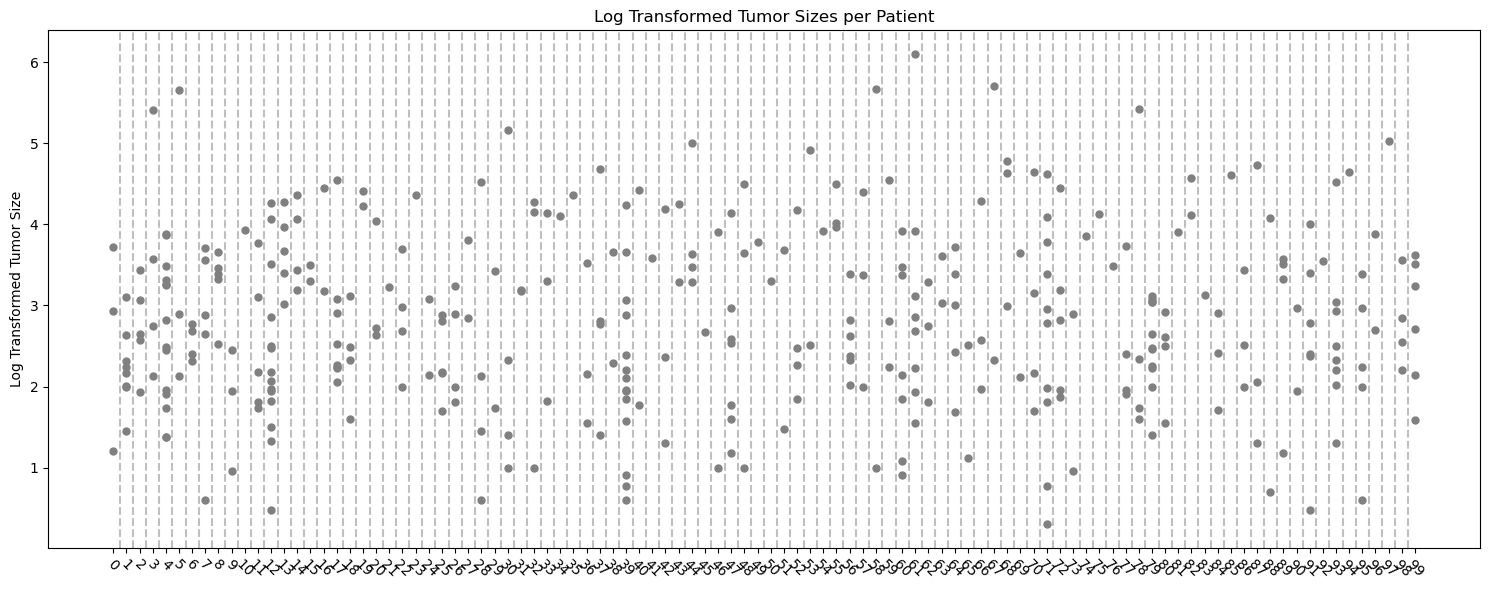

NameError: name '这个脚本首先创建一个示例' is not defined

In [61]:

tumor_size_df_log = np.log10(tumor_size_df)
tumor_size_df_log = tumor_size_df_log.iloc[0:100,]

# 绘图
fig, ax = plt.subplots(figsize=(15, 6))

for i, (index, row) in enumerate(tumor_size_df_log.iterrows()):
    # 获取所有非零的肿瘤大小值（经过对数变换）
    tumor_sizes = row[row > 0].values
    # 绘制每个非零肿瘤大小
    ax.plot([i] * len(tumor_sizes), tumor_sizes, 'o', markersize=5,color='grey')
    # 在病人之间画虚线隔开
    if i < len(tumor_size_df_log) - 1:
        ax.axvline(x=i + 0.5, linestyle='--', color='grey', alpha=0.5)

# 设置图例和标签
ax.set_xticks(range(len(tumor_size_df_log)))
ax.set_xticklabels(np.arange(0,100), rotation=-45)
ax.set_ylabel('Log Transformed Tumor Size')
ax.set_title('Log Transformed Tumor Sizes per Patient')

plt.tight_layout()
plt.show()
这个脚本首先创建一个示例

In [36]:
# 假设df是原始的DataFrame

# 计算每个病人的肿瘤数量
tumor_counts = tumor_size_df['Patient'].value_counts()

# 确定需要的列数（最大的肿瘤数量）
max_tumors = tumor_counts.max()


Patient
CILM_CT_100330_0000.nii.gz    1
CILM_CT_319590_0000.nii.gz    1
CILM_CT_299770_0000.nii.gz    1
CILM_CT_300650_0000.nii.gz    1
CILM_CT_301360_0000.nii.gz    1
                             ..
CILM_CT_215870_0000.nii.gz    1
CILM_CT_217000_0000.nii.gz    1
CILM_CT_217670_0000.nii.gz    1
CILM_CT_217910_0000.nii.gz    1
CILM_CT_994000_0000.nii.gz    1
Name: count, Length: 249, dtype: int64

In [ ]:

# 创建新的DataFrame，以病人为索引，列为每个可能的肿瘤
patients = tumor_counts.index
columns = ['Tumor {}'.format(i+1) for i in range(max_tumors)]
wide_df = pd.DataFrame(index=patients, columns=columns).fillna(0)

# 遍历原始DataFrame，填充新的DataFrame
for index, row in tumor_size_df.iterrows():
    patient = row['Patient']
    tumor_size = row['Tumor Size']
    # 找到该病人当前填充到的位置
    current_tumor_count = wide_df.loc[patient].astype(bool).sum()
    wide_df.at[patient, 'Tumor {}'.format(current_tumor_count + 1)] = tumor_size



In [56]:
wide_df = wide_df.sort_values(by='Patient')

In [63]:
wide_df_subset = wide_df.iloc[0:100,]

In [64]:
wide_df_subset

,Tumor 1,Tumor 2,Tumor 3,Tumor 4,Tumor 5,Tumor 6,Tumor 7,Tumor 8,Tumor 9,Tumor 10,...,Tumor 17,Tumor 18,Tumor 19,Tumor 20,Tumor 21,Tumor 22,Tumor 23,Tumor 24,Tumor 25,Tumor 26
Patient,,,,,,,,,,,,,,,,,,,,,
CILM_CT_100330_0000.nii.gz,389,2637,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_100430_0000.nii.gz,185,39,64,84,68,600,11,49,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_101040_0000.nii.gz,71,20,527,1275,101,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_102030_0000.nii.gz,115333,1,1,1,266,1750,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_107020_0000.nii.gz,105,4,6,796,3461,1016,1391,4,14,107,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CILM_CT_221440_0000.nii.gz,1213,1,88,434,41,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_226150_0000.nii.gz,3703,265,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_227620_0000.nii.gz,51831,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假设 df 是您的 DataFrame

plt.figure(figsize=(15, 6))

# 获取病人的总数
num_patients = wide_df_subset.shape[0]

# 生成每个病人的x坐标，用于绘图
patient_indices = np.arange(num_patients)

# 遍历每个肿瘤列
for col in wide_df_subset.columns:
    # 忽略非肿瘤大小的列（如果有的话）
    if col.startswith('Tumor'):
        # 获取当前肿瘤的所有大小
        tumor_sizes = wide_df_subset[col]
        
        # 绘制散点图，为了避免重叠，对x坐标轻微偏移
        plt.scatter(patient_indices + np.random.uniform(-0.1, 0.1, num_patients), tumor_sizes, alpha=0.6)

# 为每两个病人之间添加虚线
for i in patient_indices[:-1]:
    plt.axvline(x=i + 0.5, color='grey', linestyle='--', alpha=0.5)

# 设置图表标题和轴标签
plt.title('Tumor Size per Patient')
plt.xlabel('Patient Index')
plt.ylabel('Tumor Size')
plt.yscale('log')  # 使用对数刻度以更好地展示范围广泛的数据
plt.xticks(patient_indices, wide_df_subset.index, rotation=90)  # 设置x轴刻度标签为病人ID

plt.tight_layout()
plt.show()


NameError: name 'wide_df_subset' is not defined

<Figure size 1500x600 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 wide_df_subset 是您的 DataFrame，其中已经是一个子集，每行代表一个病人，每列代表一个肿瘤的大小

# 绘制散点图
plt.figure(figsize=(12, 6))

# 获取病人的总数
num_patients = len(wide_df_subset)

# 遍历每个病人的每个肿瘤
for i in range(num_patients):
    # 选取当前病人的行并去除所有0值（未观察到的肿瘤）
    tumor_sizes = wide_df_subset.iloc[i][wide_df_subset.iloc[i] > 0]
    x_values = np.full(len(tumor_sizes), i + 1)  # 使用病人序号作为x值，从1开始
    
    # 绘制散点图
    plt.scatter(x_values, tumor_sizes, alpha=0.6,color='gray')

# 在每两个病人之间添加虚线
for i in range(0, num_patients+1):
    plt.axvline(x=i + 0.5, color='grey', linestyle='--', alpha=0.5)

# 设置y轴为对数尺度
plt.yscale('log')

# 设置图表标题和轴标签
plt.xlabel('Patient Number')
plt.ylabel('Tumor Size')
plt.title('Tumor Size per Patient')

# 设置x轴的刻度标签为1到num_patients的数字
plt.xticks(np.arange(1, num_patients + 1), np.arange(1, num_patients + 1), rotation=45)

plt.tight_layout()  # 调整布局
plt.show()


NameError: name 'wide_df_subset' is not defined

<Figure size 1200x600 with 0 Axes>

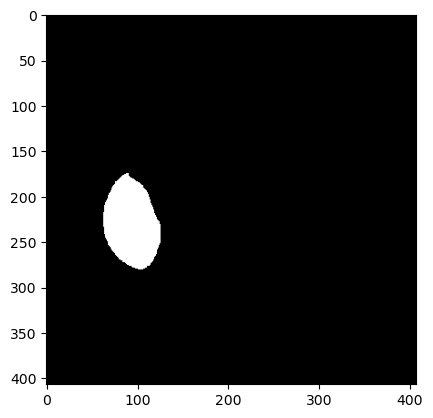

In [17]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
mask_1 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_mask_07071/CILM_CT_100330.nii.gz')
mask_1_array = sitk.GetArrayFromImage(mask_1)
plt.imshow(mask_1_array[100,:,:],cmap='gray')

In [8]:
os.listdir('../../Data/Mixed_HGP/')

['download_success.json',
 'Falut_resample',
 'largest_tm_lv_+20',
 'largest_tm_lv_07071_+20',
 'largest_tm_lv_07071_windowed_+20',
 'Mixed_HGP_07071',
 'Mixed_HGP_mask_07071',
 'Mixed_HGP_Raw',
 'Mixed_HGP_Tumor_Bbox.txt',
 'Mxied_HGP_mask',
 'overlaped_per_tumor',
 'overlaped_per_tumor_07071',
 'tm_slices_lv_region',
 'tm_slices_lv_region_+3',
 'tm_slices_lv_region_+3_07073',
 'tm_slices_lv_region_+3_07073_clipped',
 'tm_slices_lv_region_+3_07073_windowed',
 'tm_slices_lv_region_07073',
 'tm_slices_lv_region_07073_windowed',
 'True_Label']

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# 假设df是原始的DataFrame，已经包含Patient和Tumor Size两列
# 首先，给每个病人分配一个唯一的数值ID
patients = wide_df.iloc[0:1,]
patients = wide_df['Patient'].unique()
patient_ids = {patient: i for i, patient in enumerate(patients)}

# 绘制散点图
plt.figure(figsize=(12, 6))
for patient in patients:
    patient_id = patient_ids[patient]
    tumor_sizes = wide_df[wide_df['Patient'] == patient]['Tumor Size']
    x_coords = [patient_id] * len(tumor_sizes)  # 每个病人的所有肿瘤都绘制在相同的x坐标
    plt.scatter(x_coords, tumor_sizes, alpha=0.6)

# 添加虚线分隔病人
for i in range(len(patients) - 1):
    plt.axvline(x=i + 0.5, color='grey', linestyle='--', alpha=0.5)

plt.xticks(range(len(patients)), patients, rotation=90)
plt.yscale('log')
plt.xlabel('Patient ID')
plt.ylabel('Tumor Size')
plt.title('Tumor Size per Patient with Separation Lines')
plt.tight_layout()
plt.show()



KeyError: 'Patient'

In [21]:

# 将DataFrame转换为长格式
melted_df = df_subset.reset_index().melt(id_vars='index', var_name='Tumor', value_name='Size')
#must sort by samples!
melted_df.sort_values(by='index', inplace=True)

,index,Tumor,Size
0,0,Patient,CILM_CT_100330_0000.nii.gz
100,0,Tumor Size,389
1,1,Patient,CILM_CT_100330_0000.nii.gz
101,1,Tumor Size,2637
2,2,Patient,CILM_CT_100330_0000.nii.gz
...,...,...,...
97,97,Patient,CILM_CT_117840_0000.nii.gz
198,98,Tumor Size,17026
98,98,Patient,CILM_CT_117840_0000.nii.gz
99,99,Patient,CILM_CT_117840_0000.nii.gz


# largest tumor slices


In [8]:
largest_tumor_20 = os.listdir('../../Data/Mixed_HGP/overlaped_per_tumor_07071/')
largest_tumor_20 = [os.path.abspath(os.path.join('../../Data/Mixed_HGP/overlaped_per_tumor_07071/',f)) for f in os.listdir('../../Data/Mixed_HGP/overlaped_per_tumor_07071/')]
largest_tumor_20.sort()
tumor_size_per_patient_20 = []
for index,img in enumerate(largest_tumor_20):
    image = sitk.ReadImage(img)
    image_array = sitk.GetArrayFromImage(image)
    tumor_size_per_patient_20.append(image_array.shape[0])
    

(array([ 27.,  42.,  47.,  60., 151.,  23.,  98.,  16.,  52.,   8.,  16.,
          4.,  13.,   3.,   8.,   5.,   1.,   5.,   3.,   2.,   1.,   2.,
          0.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,
          1.,   3.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([  3.  ,   5.64,   8.28,  10.92,  13.56,  16.2 ,  18.84,  21.48,
         24.12,  26.76,  29.4 ,  32.04,  34.68,  37.32,  39.96,  42.6 ,
         45.24,  47.88,  50.52,  53.16,  55.8 ,  58.44,  61.08,  63.72,
         66.36,  69.  ,  71.64,  74.28,  76.92,  79.56,  82.2 ,  84.84,
         87.48,  90.12,  92.76,  95.4 ,  98.04, 100.68, 103.32, 105.96,
        108.6 , 111.24, 113.88, 116.52, 119.16, 121.8 , 124.44, 127.08,
        129.72, 132.36, 135.  ]),
 <BarContainer object of 50 artists>)

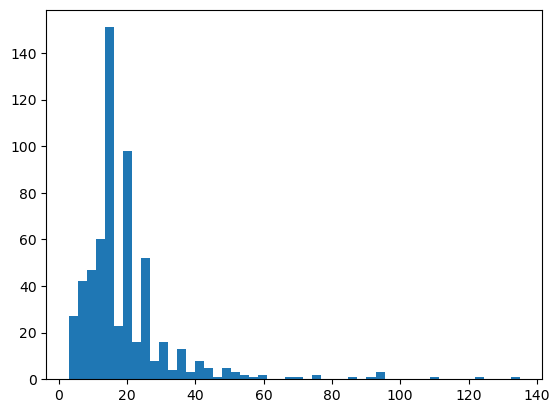

In [9]:
plt.hist(tumor_size_per_patient_20,bins=50)

In [38]:
wide_df.iloc[0:100,]

,Tumor 1,Tumor 2,Tumor 3,Tumor 4,Tumor 5,Tumor 6,Tumor 7,Tumor 8,Tumor 9,Tumor 10,...,Tumor 17,Tumor 18,Tumor 19,Tumor 20,Tumor 21,Tumor 22,Tumor 23,Tumor 24,Tumor 25,Tumor 26
Patient,,,,,,,,,,,,,,,,,,,,,
CILM_CT_333200_0000.nii.gz,128,485,277,259,4275,97,656,174,25,32,...,80,517,410,19,102,37,185,5,12,76
CILM_CT_183410_0000.nii.gz,115,4,2,31,615490,16,4,1,5,1,...,1,2,1,1,1,1,3,2,1,0
CILM_CT_271390_0000.nii.gz,410975,1,1,1,2,1,2,1,1,1,...,1,1,3,6,9,8,1,0,0,0
CILM_CT_198620_0000.nii.gz,27,20426,3087,398,4,1,1,1,2,1,...,1169,6015,301,42,0,0,0,0,0,0
CILM_CT_229580_0000.nii.gz,19857,665,1,67,2,203,438478,4426,50,2,...,1,29,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CILM_CT_152830_0000.nii.gz,2183,2,15221,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_205920_0000.nii.gz,12,130068,27,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CILM_CT_119090_0000.nii.gz,591,6,79,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 假设 'df' 是您的DataFrame
df_subset = wide_df.iloc[0:100,]

# 将DataFrame转换为长格式
melted_df = df_subset.reset_index().melt(id_vars='Patient', var_name='Tumor', value_name='Size')


In [53]:
melted_df.sort_index()

,Patient,Tumor,Size
0,CILM_CT_333200_0000.nii.gz,Tumor 1,128
1,CILM_CT_183410_0000.nii.gz,Tumor 1,115
2,CILM_CT_271390_0000.nii.gz,Tumor 1,410975
3,CILM_CT_198620_0000.nii.gz,Tumor 1,27
4,CILM_CT_229580_0000.nii.gz,Tumor 1,19857
...,...,...,...
2595,CILM_CT_152830_0000.nii.gz,Tumor 26,0
2596,CILM_CT_205920_0000.nii.gz,Tumor 26,0
2597,CILM_CT_119090_0000.nii.gz,Tumor 26,0
2598,CILM_CT_114470_0000.nii.gz,Tumor 26,0


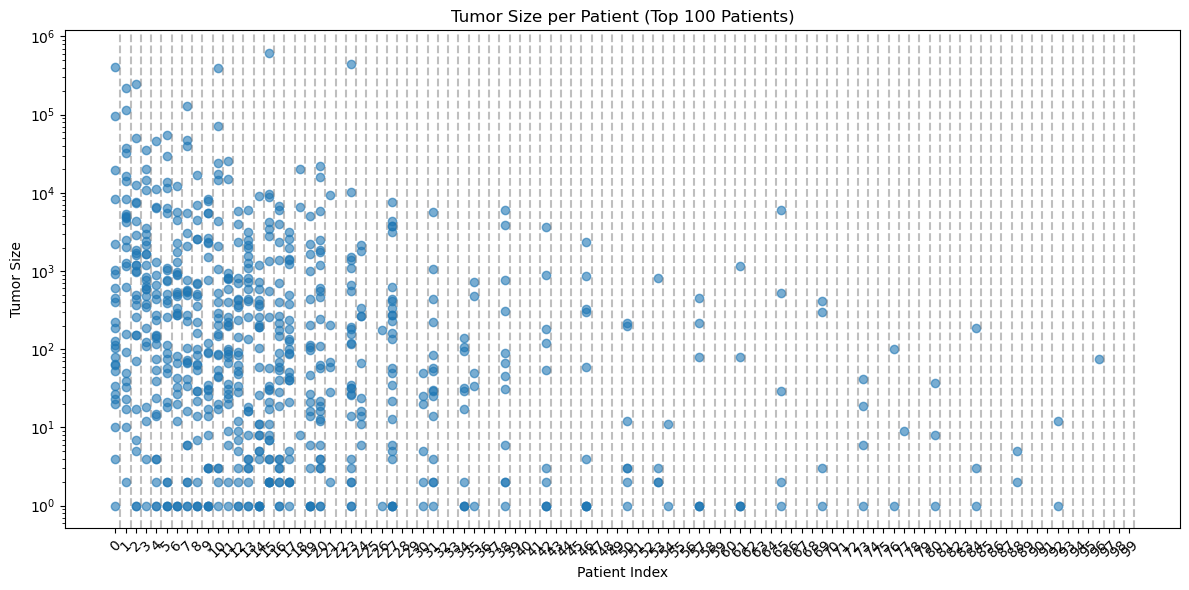

In [54]:

# 创建一个与melted_df长度相同的x轴数据
x_values = np.repeat(np.arange(100), len(melted_df) // 100)

# 绘制散点图，使用x_values作为x轴的值
plt.figure(figsize=(12, 6))
plt.scatter(x_values, melted_df['Size'], alpha=0.6)

# 为每两个病人之间添加虚线
for i in range(100):
    plt.axvline(x=i + 0.5, color='grey', linestyle='--', alpha=0.5)

# 设置y轴为对数尺度
plt.yscale('log')

# 设置X轴刻度
plt.xticks(np.arange(0, 100), rotation=45)

plt.xlabel('Patient Index')
plt.ylabel('Tumor Size')
plt.title('Tumor Size per Patient (Top 100 Patients)')
plt.tight_layout()  # 调整布局以


In [110]:
#get the liver bounding box
liver_bounding_df = pd.DataFrame(liver_bounding)
liver_bounding_df['range_col'] = liver_bounding_df['max_col'] - liver_bounding_df['min_col']
liver_bounding_df['range_row'] = liver_bounding_df['max_row'] - liver_bounding_df['min_row']


In [126]:
#use liver_bounding_df replace liver_tumor_info to get the tumor bounding box
liver_tumore_info['min_row'] = liver_bounding_df['min_row']
liver_tumore_info['min_col'] = liver_bounding_df['min_col']
liver_tumore_info['max_row'] = liver_bounding_df['max_row']
liver_tumore_info['max_col'] = liver_bounding_df['max_col']

In [129]:
liver_tumore_info.to_csv('../../Data/Mixed_HGP/Mixed_HGP_tm_slice_lv_region.csv',index=False)

In [84]:
liver_tumore_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_tumor_slices_liver.csv')

In [24]:
min_slice,max_slice = liver_tumore_info.iloc[0,].min_slice,liver_tumore_info.iloc[0,].max_slice
mask_tumor_0 = mask_1_array[min_slice:max_slice,:,:]

In [37]:
mask_tumor_0[mask_tumor_0 == 2] = 1

In [42]:
#find slice with largest value
image_probs = skimage.measure.regionprops((mask_tumor_0))

# get the bounding box of the liver
for probs in image_probs:
    bbox = probs.bbox
    min_slice, min_row, min_col, max_slice, max_row, max_col = bbox 
    print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)
    break

this is range 128 61 0 372 320 18


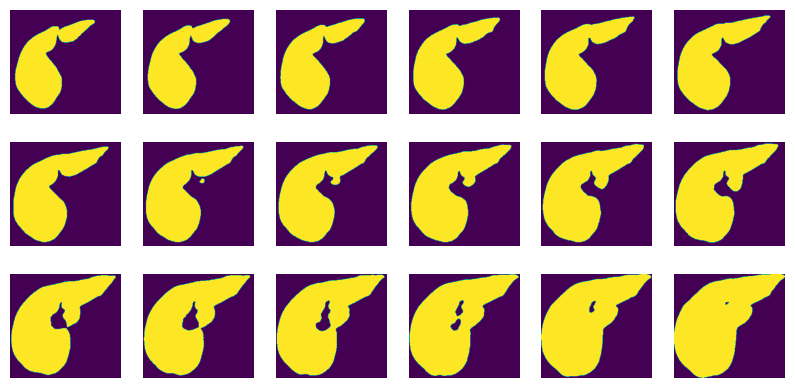

(0.7421875, 0.7421875, 3.0)

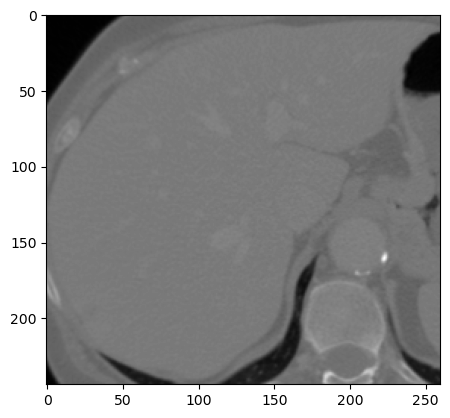

In [153]:
test = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_07073/CILM_CT_550460_0000.nii.gz'))
plt.imshow(test[11,:,:],cmap='gray')
test[0,min_row:max_row,min_col:max_col].shape



sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_07073/CILM_CT_550460_0000.nii.gz').GetSpacing()

# find tumor slices by cumsum

In [55]:
def find_tumor_slices(tumor_mask):
    """
    find the tumor slices
    args:
        tumor_mask: the tumor mask
    """
    cumsum_0 = np.cumsum(mask_tumor_0,axis=0)
    cumsum_lst_0 = []
    for i in range(cumsum_0.shape[0]):
        cumsum_lst_0.append(cumsum_0[i,:,:].sum())
    gradient = np.gradient(cumsum_lst_0)
    last_zero_index = len(gradient) - 1

    #start index
    start_index = next(i for i, v in enumerate(gradient) if v > 0)
    #end index
    for i in range(len(gradient) - 1, -1,-1):
        if gradient[i] != 0:
            # 当遇到非0元素时，记录其后一个索引为最后一个0的索引
            last_zero_index = i + 1
            break
    
    return (start_index,last_zero_index)





,Experiment,min_row,min_col,min_slice,max_row,max_col,max_slice
0,CT_10033,128,61,58,372,320,76
1,CT_10043,124,62,140,380,319,203
2,CT_10104,88,61,82,369,330,104
3,CT_10203,93,48,146,385,353,194
4,CT_10702,143,95,108,372,318,156
...,...,...,...,...,...,...,...
244,CT_89320,118,38,289,345,238,343
245,CT_94131,100,43,97,370,260,113
246,CT_94912,99,35,8,350,274,31
247,CT_97575,131,99,0,334,313,6


In [69]:
tumor_slices_df = pd.DataFrame(tumor_slices)


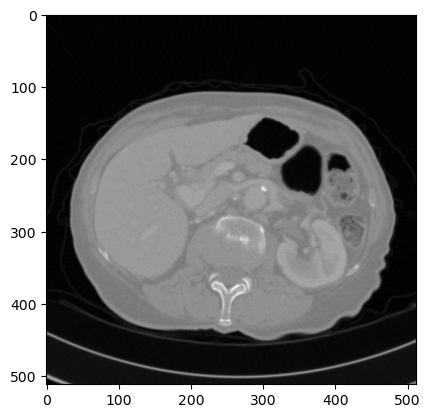

In [75]:
test_0 = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Raw/CILM_CT_100330_0000.nii.gz'))
plt.imshow(test_0[65,127:394,:],cmap='gray')

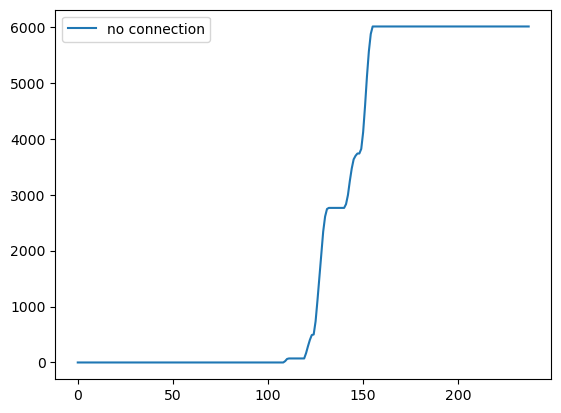

In [13]:
cumsum_0 = np.cumsum(mask_tumor_0,axis=0)
cumsum_lst_0 = []
for i in range(cumsum_0.shape[0]):
    cumsum_lst_0.append(cumsum_0[i,:,:].sum())



plt.plot(cumsum_lst_0,label='no connection')
plt.legend()


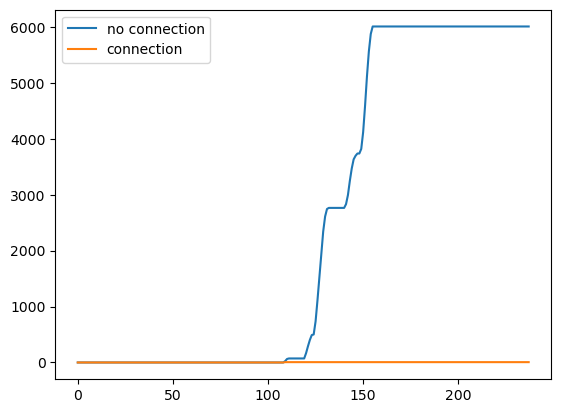

In [85]:
#cumsum from the third dimension
cumsum_0 = np.cumsum(mask_tumor_0,axis=0)
cumsum_1 = np.cumsum(mask_tumor_1,axis=0)

#Plot the cumsum AS A line
cumsum_lst_0 = []
cumsum_lst_1 = []
for i in range(cumsum_0.shape[0]):
    cumsum_lst_0.append(cumsum_0[i,:,:].sum())
    cumsum_lst_1.append(cumsum_1[i,:,:].sum())


plt.plot(cumsum_lst_0,label='no connection')
plt.plot(cumsum_lst_1,label='connection')
plt.legend()


In [160]:
cumsum_0[155,:,:].sum()

6010

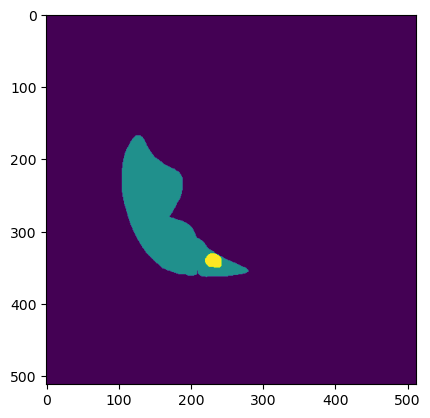

In [125]:
liver_mask = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/Mixed_HGP/Mxied_HGP_mask/CILM_CT_107020.nii.gz'))
plt.imshow(liver_mask[126,:,:])

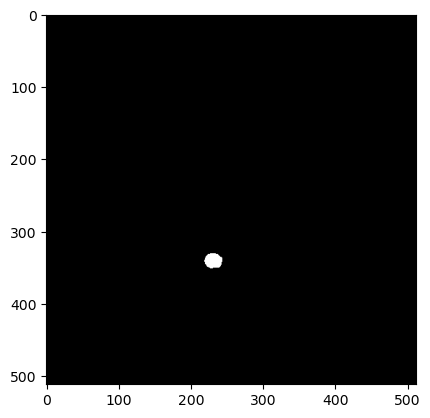

In [121]:
plt.imshow(mask_tumor_0[127,:,:],cmap='gray')
#plt.imshow(mask_tumor_1[127,:,:],cmap='gray')

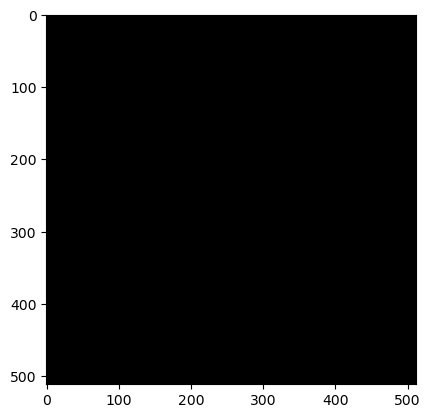

In [35]:
plt.imshow(mask_tumor[,:,:],cmap='gray')

In [36]:
liver_info_orign = pd.read_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_tm_slice_lv_region.csv')
liver_info_orign.to_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_tm_slice_lv_region.csv',index=False)

In [31]:
min_slice = liver_info['min_slice'] - 3
max_slice = liver_info['max_slice'] + 3
min_slice = min_slice.clip(lower=0)

max_slice = liver_info.apply(lambda x: x['max_slice'] + 3 if x['max_slice'] + 3 <= x['slice_range'] else x['slice_range'],axis=1)

liver_info['min_slice'] = min_slice
liver_info['max_slice'] = max_slice

In [33]:
liver_info.to_csv('../../Data/Mixed_HGP/True_Label/tm_slices_lv_region_+3.csv',index=False)

In [10]:
#get data range
#load the images
#image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_Raw/")
image_seg_load = ImageLoad("../../Data/Mixed_HGP/Mxied_HGP_mask/")

In [15]:
slices_range = {'min':[],'max':[]}
for i in range(image_seg_load.images_num):
    file_name = image_seg_load.images_names[i]

    # load the image
    #image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    print(file_name)
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    mask_tumor = sitk.GetArrayFromImage(image_seg)
    slices_range['max'].append(mask_tumor.shape[0])


CILM_CT_100330.nii.gz
CILM_CT_100430.nii.gz
CILM_CT_101040.nii.gz
CILM_CT_102030.nii.gz
CILM_CT_107020.nii.gz
CILM_CT_107850.nii.gz
CILM_CT_108710.nii.gz
CILM_CT_109290.nii.gz
CILM_CT_109300.nii.gz
CILM_CT_109540.nii.gz
CILM_CT_109630.nii.gz
CILM_CT_111110.nii.gz
CILM_CT_111360.nii.gz
CILM_CT_111550.nii.gz
CILM_CT_114470.nii.gz
CILM_CT_116550.nii.gz
CILM_CT_116560.nii.gz
CILM_CT_117840.nii.gz
CILM_CT_119090.nii.gz
CILM_CT_119760.nii.gz
CILM_CT_120170.nii.gz
CILM_CT_121900.nii.gz
CILM_CT_122760.nii.gz
CILM_CT_125750.nii.gz
CILM_CT_127240.nii.gz
CILM_CT_129060.nii.gz
CILM_CT_129270.nii.gz
CILM_CT_129570.nii.gz
CILM_CT_131630.nii.gz
CILM_CT_132360.nii.gz
CILM_CT_133290.nii.gz
CILM_CT_134160.nii.gz
CILM_CT_134190.nii.gz
CILM_CT_136510.nii.gz
CILM_CT_137140.nii.gz
CILM_CT_138590.nii.gz
CILM_CT_138850.nii.gz
CILM_CT_139990.nii.gz
CILM_CT_140250.nii.gz
CILM_CT_141420.nii.gz
CILM_CT_141510.nii.gz
CILM_CT_142300.nii.gz
CILM_CT_142490.nii.gz
CILM_CT_142990.nii.gz
CILM_CT_143590.nii.gz
CILM_CT_14

In [35]:
liver_info_orign['slice_range'] = slices_range_df[0]

In [ ]:
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]
    image_orign,image_segg = image_orig_load.image_load(image_orig_load.image_path[i]),image_seg_load.image_load(image_seg_load.image_path[i])

    #finding bounding box
    liver_bbox = LiverBoundingBox(image_segg,image_orign,cropped_out_path,file_name)
    liver_mask = liver_bbox.extract_liver()
    if liver_bbox.liver_detection(liver_mask):
        liver_box_range = liver_bbox.get_liver_bounding_box(liver_mask)
        image_liver_slice[file_name] = liver_box_range
        
    else:
        liver_bbox._recording_failing()

In [276]:
range_lst

[323, 157, 43, 359, 183, 79]

In [277]:
import ast
liver_info = pd.DataFrame(pd.read_table('../../Data/Mixed_HGP/Mixed_HGP_Tumor_Bbox.txt',sep=',',header=None))
new_columns =[]

for index, row in liver_info.iterrows():
    range_lst = row[1:].tolist()
    #range_lst = ' '.join(range_lst)
    #range_lst = ast.literal_eval(range_lst)
    min_row,min_col,min_slice,max_row,max_col,max_slice = zip(range_lst)
    new_columns.append({'min_row':min_row[0],
                        'min_col':min_col[0],
                        'min_slice':min_slice[0],
                        'max_row':max_row[0],
                        'max_col':max_col[0],
                        'max_slice':max_slice[0]})

df = pd.DataFrame(new_columns)
#join the df with the original df

liver_info = pd.concat([liver_info,df],axis=1)
#DELETE 1,2,3,4,5,6column

liver_info.drop(columns=[1,2,3,4,5,6],inplace=True)

In [285]:
a = [1,2,3]
a,b,c = 

SyntaxError: invalid syntax (481099110.py, line 2)

In [288]:
liver_info.to_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_Tumor_Bbox.csv',index=False)

In [343]:
#remove duplicates
def get_margin_size(origin_shape,range,percentage=0.1):
    """
    get the margin size of the cropped image
    args:
        origin_shape: the shape of the original image
        percentage: the percentage of the margin
        range: the range of the bounding box
    """
    min_row,min_col,min_slice,max_row,max_col,max_slice = range
    print(min_row,min_col,min_slice,max_row,max_col,max_slice,'shit')
    slice_bound,row_bound,col_bound = origin_shape.shape
    min_row = max(0,min_row - int(min_row * percentage))
    min_col = max(0,min_col - int(min_col * percentage))
    min_slice = max(0,min_slice - int(min_slice * percentage))
    max_row = min(row_bound,max_row + int(max_row * percentage))
    max_col = min(col_bound,max_col + int(max_col * percentage))
    max_slice = min(slice_bound,max_slice + int(max_slice * percentage))
    return min_row,min_col,min_slice,max_row,max_col,max_slice
        
    

In [96]:
#set the first column to Experiment

Mixed_Data = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info.csv')
Experiment_name = Mixed_Data['Experiment'].values.tolist()

liver_info[0] = Experiment_name
#change colum name
liver_info.rename(columns={0:'Experiment'},inplace=True)


In [18]:
image_orign = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz')
image_orign.shape

(521, 521, 112)

# Get Liver 07073 images


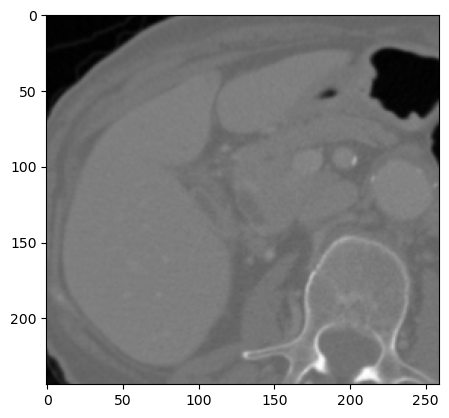

In [144]:
test_data = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region/CILM_CT_100330_0000.nii.gz')
test_data_array = sitk.GetArrayFromImage(test_data)
plt.imshow(test_data_array[0,:,:],cmap='gray')

In [44]:
liver_info

,Experiment,min_row,min_col,min_slice,max_row,max_col,max_slice,slice_range
0,CT_10033,128,61,55,372,320,79,125
1,CT_10043,124,62,137,380,319,206,210
2,CT_10104,88,61,79,369,330,107,112
3,CT_10203,93,48,143,385,353,197,311
4,CT_10702,143,95,105,372,318,159,238
...,...,...,...,...,...,...,...,...
244,CT_89320,118,38,286,345,238,346,668
245,CT_94131,100,43,94,370,260,116,204
246,CT_94912,99,35,5,350,274,34,88
247,CT_97575,131,99,0,334,313,9,64


In [46]:
import pandas as pd
liver_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/tm_slices_lv_region_+3.csv')
liver_info


,Experiment,min_row,min_col,min_slice,max_row,max_col,max_slice,slice_range
0,CT_10033,128,61,55,372,320,79,125
1,CT_10043,124,62,137,380,319,206,210
2,CT_10104,88,61,79,369,330,107,112
3,CT_10203,93,48,143,385,353,197,311
4,CT_10702,143,95,105,372,318,159,238
...,...,...,...,...,...,...,...,...
244,CT_89320,118,38,286,345,238,346,668
245,CT_94131,100,43,94,370,260,116,204
246,CT_94912,99,35,5,350,274,34,88
247,CT_97575,131,99,0,334,313,9,64


In [48]:

image_folder = '../../Data/Mixed_HGP/Mixed_HGP_Raw/'


Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Raw/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]
output_folder = '../../Data/Mixed_HGP/tm_slices_lv_region_+3/'
for index,row in liver_info.iterrows():
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    img_array = sitk.GetArrayFromImage(img)
    out_name = os.path.basename(Mixed_HGP_Data[index])
    min_row,min_col,min_slice,max_row,max_col,max_slice = row.iloc[1:7]
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,min_slice,max_row,max_col,max_slice,'555')
    extracted_slices = img_array[min_slice:max_slice,min_row:max_row, min_col:max_col]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())

    # 保存提取的切片
    sitk.WriteImage(extracted_img, output_path)

128 61 55 372 320 79 555
124 62 137 380 319 206 555
88 61 79 369 330 107 555
93 48 143 385 353 197 555
143 95 105 372 318 159 555
140 101 52 335 380 79 555
56 59 340 329 314 461 555
87 38 38 347 307 76 555
148 80 100 373 325 128 555
125 91 7 341 324 41 555
136 70 111 374 203 125 555
93 46 4 372 387 43 555
130 73 393 365 345 509 555
138 43 59 387 328 81 555
129 59 103 372 317 132 555
144 58 2 391 349 34 555
160 67 14 381 348 28 555
104 71 58 336 356 81 555
155 93 70 407 324 90 555
125 76 81 380 328 96 555
150 76 13 367 318 38 555
213 62 107 425 313 117 555
182 55 13 450 298 45 555
98 58 70 345 335 83 555
115 82 65 331 250 83 555
105 55 74 365 351 97 555
131 68 22 308 272 78 555
101 75 81 364 380 113 555
137 70 62 379 264 88 555
130 28 66 381 314 85 555
96 31 29 406 429 53 555
135 47 24 409 306 72 555
10 28 19 311 309 35 555
139 69 4 360 314 28 555
157 46 121 358 250 136 555
133 56 22 356 235 35 555
103 42 0 404 283 40 555
86 44 52 348 295 78 555
140 72 1 339 390 12 555
136 73 121 365 36

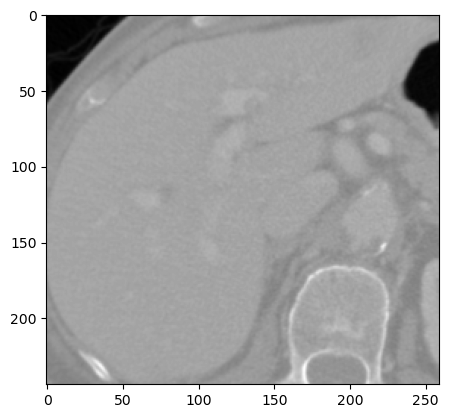

In [69]:
test_data = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_+3/CILM_CT_100330_0000.nii.gz')
test_data_array = sitk.GetArrayFromImage(test_data)
plt.imshow(test_data_array[20,:,:],cmap='gray')

In [10]:
test_0 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_lv_with_tumor/CILM_CT_273370_0000.nii.gz')
test_0_array = sitk.GetArrayFromImage(test_0)
test_0_array.shape
test_0.GetSpacing(),test_0.GetSize()
image = test_0
out_spacing = [0.7421875, 0.7421875, 1]

In [12]:
original_spacing = test_0.GetSpacing()
new_size = [int(round(test_0.GetSize()[i] * original_spacing[i] / out_spacing[i])) for i in range(3)]
#set resample parameters
resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(out_spacing)
resample.SetSize(new_size)
resample.SetOutputDirection(test_0.GetDirection())
resample.SetOutputOrigin(test_0.GetOrigin())
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(test_0.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkBSpline)
out_image = resample.Execute(test_0)


: 

In [113]:
out_image.GetSize(),out_image.GetSpacing()

((245, 212, 12), (0.7421875, 0.7421875, 3.0))

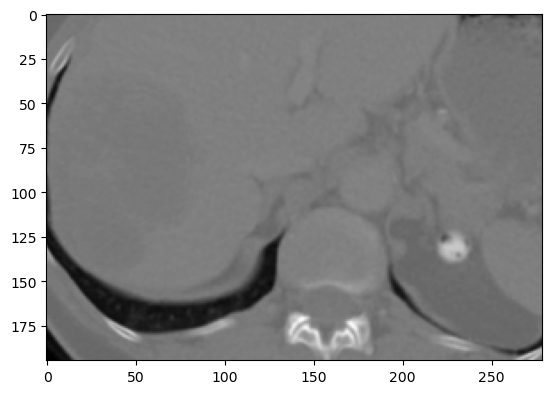

In [95]:
test_0 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_lv_with_tumor/CILM_CT_107850_0000.nii.gz')
test_0_array = sitk.GetArrayFromImage(test_0)

plt.imshow(test_0_array[12,:,:],cmap='gray')

# Windowing

In [197]:
def apply_window_to_volume(batched_volumes, window_center, window_width):
    """
    Apply windowing to a batch of 3D volumes.
    :param batched_volumes: The input batch of 3D volumes.
    :param window_center: The center of the window (window level).
    :param window_width: The width of the window.
    :return: Windowed batch of 3D volumes.
    """
    lower_bound = window_center - window_width / 2
    upper_bound = window_center + window_width / 2
    windowed_batched_volumes = np.clip(batched_volumes, lower_bound, upper_bound)
    return windowed_batched_volumes

# image = sitk.ReadImage("../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073/")
# image = sitk.GetArrayFromImage(image)
def apply_HU_values(batched_volumes,min_HU,max_HU):
    """
    Apply windowing to a batch of 3D volumes.
    :param batched_volumes: The input batch of 3D volumes.
    :param window_center: The center of the window (window level).
    :param window_width: The width of the window.
    :return: Windowed batch of 3D volumes.
    """
    lower_bound = min_HU
    upper_bound = max_HU
    windowed_batched_volumes = np.clip(batched_volumes, lower_bound, upper_bound)
    return windowed_batched_volumes
# windowed_image = apply_window_to_volume(image, 50, 400)

# plt.imshow(windowed_image[20,:,:], cmap='gray')

In [357]:
orign = sitk.ReadImage("../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/")
print(orign.GetSpacing())
orign = sitk.GetArrayFromImage(orign)

resamp = sitk.ReadImage("../../Data/Mixed_HGP/Mixed_HGP_Only_Tumor_07073/CILM_CT_100330_0000.nii.gz")
print(resamp.GetSize())
resamp = sitk.GetArrayFromImage(resamp)
resamp.shape

(0.58984375, 0.58984375, 2.0)
(74, 136, 39)


(39, 136, 74)

In [6]:
#windows the image
windowed_imgs = os.listdir('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/')
windowed_imgs = [os.path.abspath(os.path.join('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/', f)) for f in os.listdir('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/')]

output_folder = '../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_clipped/'
#os.mkdir(output_folder)
#os.mkdir(output_folder )
#os.mkdir(output_folder)
#os.mkdir(output_folder)
for index,img in enumerate(windowed_imgs):
    image = sitk.ReadImage(img)
    image_array = sitk.GetArrayFromImage(image)
    out_name = os.path.basename(img)
    output_path = os.path.join(output_folder, out_name)

    #windowed_image = apply_window_to_volume(image_array, 50, 400)
    windowed_image = apply_HU_values(image_array,-100,400)
    
    
    windowed_image = sitk.GetImageFromArray(windowed_image)
    windowed_image.SetSpacing(image.GetSpacing())
    windowed_image.SetDirection(image.GetDirection())
    windowed_image.SetOrigin(image.GetOrigin())
    sitk.WriteImage(windowed_image, output_path)
    
    

(38, 203, 180)

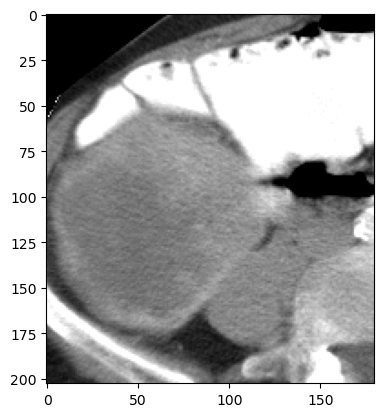

In [72]:
windowed_imgs = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_windowed/CILM_CT_177130_0000.nii.gz')
windowed_imgs = sitk.GetArrayFromImage(windowed_imgs)
plt.imshow(windowed_imgs[15,:,:], cmap='gray')
windowed_imgs.shape

In [74]:
windowed_imgs = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_clipped/CILM_CT_177130_0000.nii.gz')
windowed_imgs = sitk.GetArrayFromImage(windowed_imgs)
windowed_imgs.shape
#plt.imshow(windowed_imgs[21,:,:], cmap='gray')

(38, 203, 180)

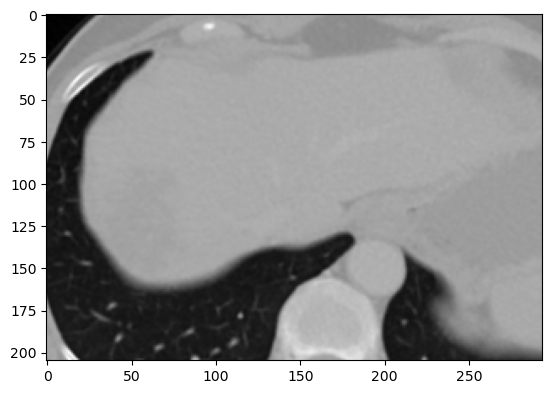

In [159]:
windowed_imgs = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_07073//CILM_CT_107850_0000.nii.gz')
windowed_imgs = sitk.GetArrayFromImage(windowed_imgs)
plt.imshow(windowed_imgs[30,:,:], cmap='gray')

In [ ]:

   


    print('saved!')

In [ ]:
    sitk.WriteImage(windowed_image, output_folder + out_name)
    print('saved!')

In [6]:
import SimpleITK as sitk
import pandas as pd
import math

def adjust_bbox(df, margin):
    """
    Adjust the bounding box dimensions by a specified margin and convert to integers.

    :param df: DataFrame with the bounding box information.
    :param margin: The margin to adjust by, as a percentage.
    """
    df['min_row'] = (df['min_row'] - (df['max_row'] - df['min_row']) * margin).clip(lower=0).apply(math.floor)
    df['max_row'] = (df['max_row'] + (df['max_row'] - df['min_row']) * margin).apply(math.ceil)
    df['min_col'] = (df['min_col'] - (df['max_col'] - df['min_col']) * margin).clip(lower=0).apply(math.floor)
    df['max_col'] = (df['max_col'] + (df['max_col'] - df['min_col']) * margin).apply(math.ceil)

    return df


NameError: name 'liver_info' is not defined

In [50]:

liver_info = pd.read_csv('../../Data/CT_Phase/Liver_slice_info.csv')
def crop_and_save_image(row, file_path, output_folder):
    """
    Crop the image based on the bounding box and save the cropped image.

    :param row: Row of the DataFrame with bounding box and file information.
    :param file_path: Path to the folder containing the images.
    :param output_folder: Folder where the cropped images will be saved.
    """
   # 读取图像
    image = sitk.ReadImage(file_path + row[0])
    image_array = sitk.GetArrayFromImage(image)

    # 获取图像尺寸
    size_x, size_y, size_z = image.GetSize()
    print("size_z",size_z)

    # 计算裁剪区域
    # start_col = max(row['min_col'], 0)
    # start_row = max(row['min_row'], 0)
    # start_slice = max(row['min_slice'], 0)

    # end_col = size_x
    # end_row = size_y
    # end_slice = min(row['max_slice'], size_z)

    start_col = row['min_col']
    start_row = row['min_row']
    start_slice = row['min_slice']

    end_col = row['max_col']
    end_row = row['max_row']
    end_slice = row['max_slice']

    


    size = [end_col - start_col, end_row - start_row, end_slice - start_slice]
    print(size)

    # 裁剪图像
    cropped_image = image_array[start_slice:end_slice, start_row:end_row, start_col:end_col]
    cropped_image = sitk.GetImageFromArray(cropped_image)    

    #print img name

    print(row[0])

    # 保存图像
    sitk.WriteImage(cropped_image, output_folder + row[0])
    print(666,[start_col, start_row, start_slice],size)
    
    print(cropped_image.GetSize())




# 调整边界框并取整
adjusted_df = adjust_bbox(liver_info, margin=0)




In [28]:
a = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/CT_Phase/Full_Image_Liver_Crop_tem/CILM_CT_101040_0000.nii.gz'))

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "../../Data/CT_Phase/Full_Image_Liver_Crop_tem/CILM_CT_101040_0000.nii.gz" does not exist.

In [51]:

# 遍历DataFrame以裁剪和保存图像
for index, row in liver_info.iterrows():
    crop_and_save_image(row, f'../../Data/CT_Phase/Full_Image_Liver/', '../../Data/CT_Phase/Full_Image_Liver_Crop_tem/')
    
        



C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = sitk.ReadImage(file_path + row[0])
C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(row[0])
C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sitk.WriteImage(cropped_image, out

size_z 112
[281, 269, 39]
CILM_CT_101040_0000.nii.gz
666 [143, 61, 72] [281, 269, 39]
(281, 269, 39)
size_z 56
[270, 305, 35]
CILM_CT_102030_0000.nii.gz
666 [146, 43, 19] [270, 305, 35]
(270, 305, 35)
size_z 37
[207, 201, 28]
CILM_CT_104550_0000.nii.gz
666 [176, 92, 7] [207, 201, 28]
(207, 201, 28)
size_z 61
[218, 322, 56]
CILM_CT_104551_0000.nii.gz
666 [169, 94, 2] [218, 322, 56]
(218, 322, 56)
size_z 79
[221, 346, 35]
CILM_CT_104552_0000.nii.gz
666 [166, 87, 42] [221, 346, 35]
(221, 346, 35)
size_z 59
[190, 284, 12]
CILM_CT_107850_0000.nii.gz
666 [178, 103, 0] [190, 284, 12]
(190, 284, 12)
size_z 127
[195, 279, 31]
CILM_CT_107851_0000.nii.gz
666 [177, 101, 48] [195, 279, 31]
(195, 279, 31)
size_z 48
[279, 341, 38]
CILM_CT_111110_0000.nii.gz
666 [140, 46, 5] [279, 341, 38]
(279, 341, 38)
size_z 42
[257, 346, 36]
CILM_CT_111111_0000.nii.gz
666 [143, 30, 0] [257, 346, 36]
(257, 346, 36)
size_z 48
[238, 347, 38]
CILM_CT_111112_0000.nii.gz
666 [176, 40, 5] [238, 347, 38]
(238, 347, 38)
si

In [38]:
import matplotlib.pyplot as plt
image_path = '../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_176841_0000.nii.gz'
image_name = 'CILM_CT_176841_0000.nii.gz'
cropped_out_path = '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

os.makedirs(cropped_out_path,exist_ok=True)
save_liver_slice(image_path,image_name,cropped_out_path,slice_margin=0.5)



(539, 539, 85) 666
min and max slice 333 528
fucking max slice 528
fucking after 85
166 85
(539, 539, 0)
saved!


In [ ]:

#save all slice that includes liver,full image not resample!
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)



In [34]:
image_orig_load = ImageLoad("../../Data/CT_Phase/Full_Image_Liver_07075/")
os.mkdir('../../Data/CT_Phase/Full_image_Liver_slice_07075/')
cropped_out_path = '../../Data/CT_Phase/Full_Image_Liver_slice_07075/'

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

In [ ]:
#resample slice includes liver
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)

# Flip

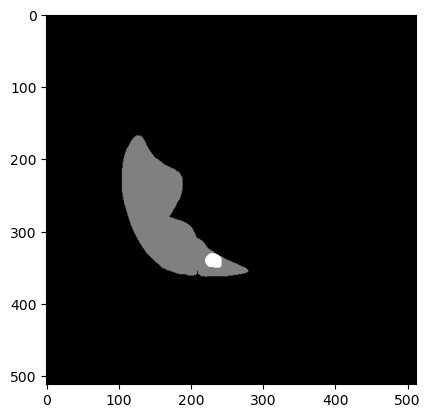

In [127]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
img = sitk.ReadImage('../../Data/Mixed_HGP/Mxied_HGP_mask/CILM_CT_107020.nii.gz')
img_array = sitk.GetArrayFromImage(img)


plt.imshow(img_array[126,:,:],cmap='gray')

In [130]:
flip_img.GetSpacing()

(0.87890625, 0.87890625, 3.0)

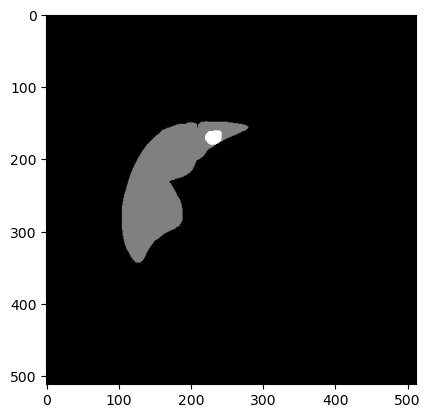

In [129]:
img_arrary = sitk.GetArrayFromImage(img)

flip_img = sitk.Flip(img,[False,True,False])


#save flipped image

filp_array = sitk.GetArrayFromImage(flip_img)
plt.imshow(filp_array[126,:,:],cmap='gray')


In [131]:
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mxied_HGP_mask/")
cropped_out_path = '../../Data/Mixed_HGP/Mxied_HGP_mask/'


for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    img_sitk = sitk.ReadImage(image_path)
    flip_img = sitk.Flip(img_sitk,[False,True,False])
    sitk.WriteImage(flip_img,cropped_out_path + file_name)

100%|██████████| 249/249 [00:18<00:00, 13.23it/s]


In [36]:
from monai.transforms import SpatialPad
pad = SpatialPad((128, 128, 30), mode='constant')
